# SentiVista: Comparing Classical ML and Transformer-based Models

This notebook implements and compares different sentiment analysis approaches:
1. Classical ML models (Naive Bayes, Logistic Regression)
2. Fine-tuned RoBERTa transformer model

All models are evaluated on the Sentiment140 dataset using the same metrics for fair comparison.

## Setup and Import Libraries

In [1]:
# Install required libraries
!pip install datasets emoji evaluate transformers==4.40.0 tqdm matplotlib seaborn joblib

# Import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
import joblib
import emoji
import torch

# NLP and ML libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Transformer-specific imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

print("Setup complete!")

Setup complete!
Setup complete!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading and Preprocessing

In [2]:
# Load Sentiment140 Dataset
df = pd.read_csv('sentiment140.csv', encoding='ISO-8859-1')
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Display dataset info
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['target'].value_counts()}")
df.head()

Dataset shape: (1599999, 6)
Target distribution:
target
4    800000
0    799999
Name: count, dtype: int64


,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
# Common preprocessing function for both classical and transformer models
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    tokens = tweet.split()
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word.lower() not in stop_words]
    tweet = ' '.join(tokens)
    return tweet

# Preprocess the text (this can take some time on the full dataset)
print("Preprocessing text data...")
df['cleaned_text'] = df['text'].apply(clean_tweet)

# Add binary target mapping for RoBERTa (0=negative, 1=positive)
def map_target(val):
    if val == 0:
        return 0  # negative
    else:  # val == 4 in original dataset
        return 1  # positive

df['label'] = df['target'].apply(map_target)

# Use the full dataset for training (removing the sampling code)
print(f"Full dataset shape: {df.shape}")
print(f"Target distribution:\n{df['label'].value_counts()}")

# Display examples
df[['text', 'cleaned_text', 'target', 'label']].head()

Preprocessing text data...
Full dataset shape: (1599999, 8)
Target distribution:
label
1    800000
0    799999
Name: count, dtype: int64
Full dataset shape: (1599999, 8)
Target distribution:
label
1    800000
0    799999
Name: count, dtype: int64


,text,cleaned_text,target,label
0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...,0,0
1,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound,0,0
2,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,0,0
3,"@nationwideclass no, it's not behaving at all....",behav mad see,0,0
4,@Kwesidei not the whole crew,whole crew,0,0


## Common Train-Test Split

We'll create a common train-test split that will be used by all models for fair comparison.

In [4]:
# Create a common train/test split for consistent evaluation
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"Train set: {train_df.shape}, Test set: {test_df.shape}")
print(f"Train label distribution:\n{train_df['label'].value_counts()}")
print(f"Test label distribution:\n{test_df['label'].value_counts()}")

Train set: (1279999, 8), Test set: (320000, 8)
Train label distribution:
label
1    640000
0    639999
Name: count, dtype: int64
Test label distribution:
label
0    160000
1    160000
Name: count, dtype: int64


## Part 1: Classical ML Models

### Feature Engineering for Classical Models

In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

# Additional features
train_df['tweet_length'] = train_df['text'].apply(len)
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
train_df['mention_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))

test_df['tweet_length'] = test_df['text'].apply(len)
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))

# Combine TF-IDF with additional features
from scipy.sparse import hstack
X_train_additional = train_df[['tweet_length', 'hashtag_count', 'mention_count']].values
X_test_additional = test_df[['tweet_length', 'hashtag_count', 'mention_count']].values

X_train_combined = hstack([X_train_tfidf, X_train_additional])
X_test_combined = hstack([X_test_tfidf, X_test_additional])

# Target values
y_train_classical = train_df['target']  # Original 0/4 targets for classical models
y_test_classical = test_df['target']

print(f"Feature matrix shapes - Train: {X_train_combined.shape}, Test: {X_test_combined.shape}")

Feature matrix shapes - Train: (1279999, 10003), Test: (320000, 10003)


### Train Classical Models

In [6]:
# Define a dictionary to store all models and their results
models = {}
results = {}

# Training classical models on the full dataset might take time
print("Training Naive Bayes on full dataset...")
nb_model = MultinomialNB()
nb_model.fit(X_train_combined, y_train_classical)
models['Naive Bayes'] = nb_model

# Train Logistic Regression with increased max_iter for convergence on larger dataset
print("Training Logistic Regression on full dataset...")
lr_model = LogisticRegression(max_iter=2000, solver='liblinear', n_jobs=-1)
lr_model.fit(X_train_combined, y_train_classical)
models['Logistic Regression'] = lr_model

print("Classical models training complete!")

Training Naive Bayes on full dataset...
Training Logistic Regression on full dataset...
Training Logistic Regression on full dataset...


c:\Users\queri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Classical models training complete!


## Part 2: RoBERTa Transformer Model

### Prepare Data for RoBERTa

In [7]:
# Set up tokenizer for RoBERTa
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], truncation=True, padding='max_length', max_length=128)

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['cleaned_text', 'label']].reset_index(drop=True))

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Data preparation for RoBERTa complete!")

c:\Users\queri\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/1279999 [00:00<?, ? examples/s]

Map:   0%|          | 0/320000 [00:00<?, ? examples/s]

Data preparation for RoBERTa complete!


### Train RoBERTa Model

In [ ]:
# Load the pre-trained model for binary classification
# Add ignore_mismatched_sizes=True to handle the label count difference (pre-trained model has 3 classes)
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    ignore_mismatched_sizes=True  # This parameter allows loading with different output layer sizes
)

# Enhanced training arguments for better performance
from transformers import get_scheduler

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Increased from 1 to 3 for better performance
    per_device_train_batch_size=16,  # Reduced for larger dataset to avoid memory issues
    per_device_eval_batch_size=32,
    evaluation_strategy='steps',  # Evaluate at steps rather than just epochs for better monitoring
    eval_steps=1000,  # Evaluate every 1000 steps
    save_strategy='steps',
    save_steps=1000,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',  # Use accuracy instead of loss
    save_total_limit=2,  # Keep more checkpoints
    report_to='none',  # Disable wandb reporting
    # Add learning rate scheduling
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,  # Add weight decay for regularization
    gradient_accumulation_steps=4,  # Accumulate gradients to effectively increase batch size
    fp16=True  # Use mixed precision training if GPU supports it
)

# Enhanced metrics calculation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, pos_label=1),
        'recall': recall_score(labels, predictions, pos_label=1),
        'f1': f1_score(labels, predictions, pos_label=1)
    }
    .DS_Store
    return metrics

# Create Trainer with enhanced configuration
trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model on full dataset
print("Training RoBERTa model on full dataset (this may take several hours)...")
trainer.train()

models['RoBERTa'] = trainer.model
print("RoBERTa model training complete!")

c:\Users\queri\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are n

Training RoBERTa model on full dataset (this may take several hours)...


  0%|          | 0/60000 [00:00<?, ?it/s]

{'loss': 0.6105, 'grad_norm': 3.4802708625793457, 'learning_rate': 1e-05, 'epoch': 0.01}
{'loss': 0.5314, 'grad_norm': 3.7280893325805664, 'learning_rate': 2e-05, 'epoch': 0.01}
{'loss': 0.5314, 'grad_norm': 3.7280893325805664, 'learning_rate': 2e-05, 'epoch': 0.01}
{'loss': 0.5024, 'grad_norm': 4.3956451416015625, 'learning_rate': 3e-05, 'epoch': 0.01}
{'loss': 0.5024, 'grad_norm': 4.3956451416015625, 'learning_rate': 3e-05, 'epoch': 0.01}
{'loss': 0.5115, 'grad_norm': 4.58789587020874, 'learning_rate': 4e-05, 'epoch': 0.02}
{'loss': 0.5115, 'grad_norm': 4.58789587020874, 'learning_rate': 4e-05, 'epoch': 0.02}
{'loss': 0.5042, 'grad_norm': 3.1967599391937256, 'learning_rate': 5e-05, 'epoch': 0.03}
{'loss': 0.5042, 'grad_norm': 3.1967599391937256, 'learning_rate': 5e-05, 'epoch': 0.03}
{'loss': 0.5126, 'grad_norm': 3.113467216491699, 'learning_rate': 4.991596638655463e-05, 'epoch': 0.03}
{'loss': 0.5126, 'grad_norm': 3.113467216491699, 'learning_rate': 4.991596638655463e-05, 'epoch': 0

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4871356785297394, 'eval_accuracy': 0.767825, 'eval_precision': 0.7391401401848297, 'eval_recall': 0.8278, 'eval_f1': 0.7809618151371495, 'eval_runtime': 457.3176, 'eval_samples_per_second': 699.733, 'eval_steps_per_second': 21.867, 'epoch': 0.05}
{'loss': 0.486, 'grad_norm': 6.928654193878174, 'learning_rate': 4.949579831932774e-05, 'epoch': 0.06}
{'loss': 0.486, 'grad_norm': 6.928654193878174, 'learning_rate': 4.949579831932774e-05, 'epoch': 0.06}
{'loss': 0.4805, 'grad_norm': 3.2705185413360596, 'learning_rate': 4.9411764705882355e-05, 'epoch': 0.06}
{'loss': 0.4805, 'grad_norm': 3.2705185413360596, 'learning_rate': 4.9411764705882355e-05, 'epoch': 0.06}
{'loss': 0.484, 'grad_norm': 4.272925853729248, 'learning_rate': 4.932773109243698e-05, 'epoch': 0.07}
{'loss': 0.484, 'grad_norm': 4.272925853729248, 'learning_rate': 4.932773109243698e-05, 'epoch': 0.07}
{'loss': 0.4916, 'grad_norm': 3.1067192554473877, 'learning_rate': 4.9243697478991605e-05, 'epoch': 0.07}
{'loss'

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4810645580291748, 'eval_accuracy': 0.77191875, 'eval_precision': 0.7292738195615515, 'eval_recall': 0.86491875, 'eval_f1': 0.7913254803293687, 'eval_runtime': 456.0983, 'eval_samples_per_second': 701.603, 'eval_steps_per_second': 21.925, 'epoch': 0.1}
{'loss': 0.4704, 'grad_norm': 2.6073837280273438, 'learning_rate': 4.865546218487395e-05, 'epoch': 0.1}
{'loss': 0.4704, 'grad_norm': 2.6073837280273438, 'learning_rate': 4.865546218487395e-05, 'epoch': 0.1}
{'loss': 0.4836, 'grad_norm': 4.446426868438721, 'learning_rate': 4.8571428571428576e-05, 'epoch': 0.11}
{'loss': 0.4836, 'grad_norm': 4.446426868438721, 'learning_rate': 4.8571428571428576e-05, 'epoch': 0.11}
{'loss': 0.475, 'grad_norm': 2.324713706970215, 'learning_rate': 4.8487394957983194e-05, 'epoch': 0.12}
{'loss': 0.475, 'grad_norm': 2.324713706970215, 'learning_rate': 4.8487394957983194e-05, 'epoch': 0.12}
{'loss': 0.4667, 'grad_norm': 3.3252322673797607, 'learning_rate': 4.840336134453782e-05, 'epoch': 0.12}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4891343116760254, 'eval_accuracy': 0.776084375, 'eval_precision': 0.8138280867026152, 'eval_recall': 0.71595, 'eval_f1': 0.7617578310729259, 'eval_runtime': 456.1576, 'eval_samples_per_second': 701.512, 'eval_steps_per_second': 21.922, 'epoch': 0.15}
{'loss': 0.4769, 'grad_norm': 2.8574297428131104, 'learning_rate': 4.781512605042017e-05, 'epoch': 0.15}
{'loss': 0.4769, 'grad_norm': 2.8574297428131104, 'learning_rate': 4.781512605042017e-05, 'epoch': 0.15}
{'loss': 0.4598, 'grad_norm': 2.285024642944336, 'learning_rate': 4.7731092436974796e-05, 'epoch': 0.16}
{'loss': 0.4598, 'grad_norm': 2.285024642944336, 'learning_rate': 4.7731092436974796e-05, 'epoch': 0.16}
{'loss': 0.4682, 'grad_norm': 2.515509605407715, 'learning_rate': 4.7647058823529414e-05, 'epoch': 0.17}
{'loss': 0.4682, 'grad_norm': 2.515509605407715, 'learning_rate': 4.7647058823529414e-05, 'epoch': 0.17}
{'loss': 0.4698, 'grad_norm': 3.827587842941284, 'learning_rate': 4.756302521008403e-05, 'epoch': 0.17}

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4564788043498993, 'eval_accuracy': 0.78805625, 'eval_precision': 0.7697882154606226, 'eval_recall': 0.8219125, 'eval_f1': 0.7949968866561478, 'eval_runtime': 456.584, 'eval_samples_per_second': 700.857, 'eval_steps_per_second': 21.902, 'epoch': 0.2}
{'loss': 0.465, 'grad_norm': 2.132075786590576, 'learning_rate': 4.6975630252100844e-05, 'epoch': 0.2}
{'loss': 0.465, 'grad_norm': 2.132075786590576, 'learning_rate': 4.6975630252100844e-05, 'epoch': 0.2}
{'loss': 0.4634, 'grad_norm': 2.489898920059204, 'learning_rate': 4.689159663865547e-05, 'epoch': 0.21}
{'loss': 0.4634, 'grad_norm': 2.489898920059204, 'learning_rate': 4.689159663865547e-05, 'epoch': 0.21}
{'loss': 0.4566, 'grad_norm': 3.8962044715881348, 'learning_rate': 4.680756302521009e-05, 'epoch': 0.21}
{'loss': 0.4566, 'grad_norm': 3.8962044715881348, 'learning_rate': 4.680756302521009e-05, 'epoch': 0.21}
{'loss': 0.4661, 'grad_norm': 1.8293187618255615, 'learning_rate': 4.672352941176471e-05, 'epoch': 0.22}
{'los

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.45739662647247314, 'eval_accuracy': 0.78884375, 'eval_precision': 0.8050011879306248, 'eval_recall': 0.76235625, 'eval_f1': 0.7830985734646447, 'eval_runtime': 462.9956, 'eval_samples_per_second': 691.151, 'eval_steps_per_second': 21.598, 'epoch': 0.25}
{'loss': 0.4679, 'grad_norm': 2.86240816116333, 'learning_rate': 4.613529411764706e-05, 'epoch': 0.26}
{'loss': 0.4679, 'grad_norm': 2.86240816116333, 'learning_rate': 4.613529411764706e-05, 'epoch': 0.26}
{'loss': 0.4409, 'grad_norm': 2.030566692352295, 'learning_rate': 4.605126050420168e-05, 'epoch': 0.26}
{'loss': 0.4409, 'grad_norm': 2.030566692352295, 'learning_rate': 4.605126050420168e-05, 'epoch': 0.26}
{'loss': 0.4656, 'grad_norm': 1.9814602136611938, 'learning_rate': 4.596722689075631e-05, 'epoch': 0.27}
{'loss': 0.4656, 'grad_norm': 1.9814602136611938, 'learning_rate': 4.596722689075631e-05, 'epoch': 0.27}
{'loss': 0.4434, 'grad_norm': 3.460284948348999, 'learning_rate': 4.5883193277310925e-05, 'epoch': 0.27}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.45260190963745117, 'eval_accuracy': 0.787634375, 'eval_precision': 0.7573319317158818, 'eval_recall': 0.8465125, 'eval_f1': 0.7994428065080672, 'eval_runtime': 459.5473, 'eval_samples_per_second': 696.337, 'eval_steps_per_second': 21.761, 'epoch': 0.3}
{'loss': 0.4582, 'grad_norm': 2.195157051086426, 'learning_rate': 4.529579831932773e-05, 'epoch': 0.3}
{'loss': 0.4582, 'grad_norm': 2.195157051086426, 'learning_rate': 4.529579831932773e-05, 'epoch': 0.3}
{'loss': 0.4751, 'grad_norm': 3.2639424800872803, 'learning_rate': 4.5211764705882355e-05, 'epoch': 0.31}
{'loss': 0.4751, 'grad_norm': 3.2639424800872803, 'learning_rate': 4.5211764705882355e-05, 'epoch': 0.31}
{'loss': 0.4606, 'grad_norm': 2.9894020557403564, 'learning_rate': 4.512773109243697e-05, 'epoch': 0.32}
{'loss': 0.4606, 'grad_norm': 2.9894020557403564, 'learning_rate': 4.512773109243697e-05, 'epoch': 0.32}
{'loss': 0.4664, 'grad_norm': 1.7419636249542236, 'learning_rate': 4.50436974789916e-05, 'epoch': 0.32}

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.44922080636024475, 'eval_accuracy': 0.791990625, 'eval_precision': 0.7839150172287012, 'eval_recall': 0.8062125, 'eval_f1': 0.7949074259515454, 'eval_runtime': 459.6315, 'eval_samples_per_second': 696.21, 'eval_steps_per_second': 21.757, 'epoch': 0.35}
{'loss': 0.449, 'grad_norm': 3.7810211181640625, 'learning_rate': 4.445546218487395e-05, 'epoch': 0.35}
{'loss': 0.449, 'grad_norm': 3.7810211181640625, 'learning_rate': 4.445546218487395e-05, 'epoch': 0.35}
{'loss': 0.4587, 'grad_norm': 2.225187063217163, 'learning_rate': 4.4371428571428575e-05, 'epoch': 0.36}
{'loss': 0.4587, 'grad_norm': 2.225187063217163, 'learning_rate': 4.4371428571428575e-05, 'epoch': 0.36}
{'loss': 0.4339, 'grad_norm': 2.8689119815826416, 'learning_rate': 4.4288235294117645e-05, 'epoch': 0.36}
{'loss': 0.4339, 'grad_norm': 2.8689119815826416, 'learning_rate': 4.4288235294117645e-05, 'epoch': 0.36}
{'loss': 0.4496, 'grad_norm': 1.799147605895996, 'learning_rate': 4.420420168067227e-05, 'epoch': 0.3

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4444356858730316, 'eval_accuracy': 0.794353125, 'eval_precision': 0.7877018185816651, 'eval_recall': 0.8059125, 'eval_f1': 0.7967031099879827, 'eval_runtime': 459.4292, 'eval_samples_per_second': 696.516, 'eval_steps_per_second': 21.766, 'epoch': 0.4}
{'loss': 0.4566, 'grad_norm': 2.334798812866211, 'learning_rate': 4.361596638655462e-05, 'epoch': 0.41}
{'loss': 0.4566, 'grad_norm': 2.334798812866211, 'learning_rate': 4.361596638655462e-05, 'epoch': 0.41}
{'loss': 0.4614, 'grad_norm': 2.9213922023773193, 'learning_rate': 4.353193277310925e-05, 'epoch': 0.41}
{'loss': 0.4614, 'grad_norm': 2.9213922023773193, 'learning_rate': 4.353193277310925e-05, 'epoch': 0.41}
{'loss': 0.4565, 'grad_norm': 1.9716622829437256, 'learning_rate': 4.3447899159663866e-05, 'epoch': 0.41}
{'loss': 0.4565, 'grad_norm': 1.9716622829437256, 'learning_rate': 4.3447899159663866e-05, 'epoch': 0.41}
{'loss': 0.4514, 'grad_norm': 2.052016496658325, 'learning_rate': 4.336386554621849e-05, 'epoch': 0.42

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.46684911847114563, 'eval_accuracy': 0.79428125, 'eval_precision': 0.7825619914064188, 'eval_recall': 0.81501875, 'eval_f1': 0.7984606718181707, 'eval_runtime': 459.3473, 'eval_samples_per_second': 696.641, 'eval_steps_per_second': 21.77, 'epoch': 0.45}
{'loss': 0.4405, 'grad_norm': 2.777965784072876, 'learning_rate': 4.277563025210084e-05, 'epoch': 0.46}
{'loss': 0.4405, 'grad_norm': 2.777965784072876, 'learning_rate': 4.277563025210084e-05, 'epoch': 0.46}
{'loss': 0.4455, 'grad_norm': 2.385775327682495, 'learning_rate': 4.269159663865546e-05, 'epoch': 0.46}
{'loss': 0.4455, 'grad_norm': 2.385775327682495, 'learning_rate': 4.269159663865546e-05, 'epoch': 0.46}
{'loss': 0.4375, 'grad_norm': 2.4640450477600098, 'learning_rate': 4.2607563025210086e-05, 'epoch': 0.47}
{'loss': 0.4375, 'grad_norm': 2.4640450477600098, 'learning_rate': 4.2607563025210086e-05, 'epoch': 0.47}
{'loss': 0.4441, 'grad_norm': 2.998490810394287, 'learning_rate': 4.2523529411764704e-05, 'epoch': 0.47

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4527052342891693, 'eval_accuracy': 0.791784375, 'eval_precision': 0.8131510635015394, 'eval_recall': 0.75766875, 'eval_f1': 0.7844300721812587, 'eval_runtime': 459.046, 'eval_samples_per_second': 697.098, 'eval_steps_per_second': 21.784, 'epoch': 0.5}
{'loss': 0.4473, 'grad_norm': 2.7659764289855957, 'learning_rate': 4.1935294117647064e-05, 'epoch': 0.51}
{'loss': 0.4473, 'grad_norm': 2.7659764289855957, 'learning_rate': 4.1935294117647064e-05, 'epoch': 0.51}
{'loss': 0.4427, 'grad_norm': 3.455942392349243, 'learning_rate': 4.185126050420168e-05, 'epoch': 0.51}
{'loss': 0.4427, 'grad_norm': 3.455942392349243, 'learning_rate': 4.185126050420168e-05, 'epoch': 0.51}
{'loss': 0.4465, 'grad_norm': 2.3023552894592285, 'learning_rate': 4.176722689075631e-05, 'epoch': 0.52}
{'loss': 0.4465, 'grad_norm': 2.3023552894592285, 'learning_rate': 4.176722689075631e-05, 'epoch': 0.52}
{'loss': 0.4548, 'grad_norm': 2.143460750579834, 'learning_rate': 4.1683193277310925e-05, 'epoch': 0.5

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.44008389115333557, 'eval_accuracy': 0.79214375, 'eval_precision': 0.7651633764465623, 'eval_recall': 0.84301875, 'eval_f1': 0.8022064945878434, 'eval_runtime': 460.9724, 'eval_samples_per_second': 694.185, 'eval_steps_per_second': 21.693, 'epoch': 0.55}
{'loss': 0.4447, 'grad_norm': 3.7292044162750244, 'learning_rate': 4.109495798319328e-05, 'epoch': 0.56}
{'loss': 0.4447, 'grad_norm': 3.7292044162750244, 'learning_rate': 4.109495798319328e-05, 'epoch': 0.56}
{'loss': 0.4518, 'grad_norm': 3.0832598209381104, 'learning_rate': 4.10109243697479e-05, 'epoch': 0.56}
{'loss': 0.4518, 'grad_norm': 3.0832598209381104, 'learning_rate': 4.10109243697479e-05, 'epoch': 0.56}
{'loss': 0.4477, 'grad_norm': 2.3647332191467285, 'learning_rate': 4.092773109243698e-05, 'epoch': 0.56}
{'loss': 0.4477, 'grad_norm': 2.3647332191467285, 'learning_rate': 4.092773109243698e-05, 'epoch': 0.56}
{'loss': 0.45, 'grad_norm': 2.3858702182769775, 'learning_rate': 4.0844537815126056e-05, 'epoch': 0.57

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4554392695426941, 'eval_accuracy': 0.795790625, 'eval_precision': 0.7772609304423731, 'eval_recall': 0.82920625, 'eval_f1': 0.8023937609807283, 'eval_runtime': 460.0834, 'eval_samples_per_second': 695.526, 'eval_steps_per_second': 21.735, 'epoch': 0.6}
{'loss': 0.4606, 'grad_norm': 2.2919673919677734, 'learning_rate': 4.02563025210084e-05, 'epoch': 0.6}
{'loss': 0.4606, 'grad_norm': 2.2919673919677734, 'learning_rate': 4.02563025210084e-05, 'epoch': 0.6}
{'loss': 0.4327, 'grad_norm': 2.183624029159546, 'learning_rate': 4.017226890756303e-05, 'epoch': 0.61}
{'loss': 0.4327, 'grad_norm': 2.183624029159546, 'learning_rate': 4.017226890756303e-05, 'epoch': 0.61}
{'loss': 0.4439, 'grad_norm': 2.248159408569336, 'learning_rate': 4.008823529411765e-05, 'epoch': 0.61}
{'loss': 0.4439, 'grad_norm': 2.248159408569336, 'learning_rate': 4.008823529411765e-05, 'epoch': 0.61}
{'loss': 0.45, 'grad_norm': 2.7300591468811035, 'learning_rate': 4.000420168067227e-05, 'epoch': 0.62}
{'loss

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4493575692176819, 'eval_accuracy': 0.794603125, 'eval_precision': 0.771885400504127, 'eval_recall': 0.83638125, 'eval_f1': 0.8028400961097163, 'eval_runtime': 459.8226, 'eval_samples_per_second': 695.92, 'eval_steps_per_second': 21.748, 'epoch': 0.65}
{'loss': 0.4368, 'grad_norm': 2.2858080863952637, 'learning_rate': 3.941596638655462e-05, 'epoch': 0.66}
{'loss': 0.4368, 'grad_norm': 2.2858080863952637, 'learning_rate': 3.941596638655462e-05, 'epoch': 0.66}
{'loss': 0.449, 'grad_norm': 2.128659963607788, 'learning_rate': 3.933193277310925e-05, 'epoch': 0.66}
{'loss': 0.449, 'grad_norm': 2.128659963607788, 'learning_rate': 3.933193277310925e-05, 'epoch': 0.66}
{'loss': 0.449, 'grad_norm': 2.872817277908325, 'learning_rate': 3.924789915966387e-05, 'epoch': 0.67}
{'loss': 0.449, 'grad_norm': 2.872817277908325, 'learning_rate': 3.924789915966387e-05, 'epoch': 0.67}
{'loss': 0.4327, 'grad_norm': 2.0935707092285156, 'learning_rate': 3.916386554621848e-05, 'epoch': 0.67}
{'los

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.45367223024368286, 'eval_accuracy': 0.79159375, 'eval_precision': 0.8357054455445545, 'eval_recall': 0.72589375, 'eval_f1': 0.7769386171465268, 'eval_runtime': 459.0924, 'eval_samples_per_second': 697.027, 'eval_steps_per_second': 21.782, 'epoch': 0.7}
{'loss': 0.4296, 'grad_norm': 2.4243907928466797, 'learning_rate': 3.857563025210084e-05, 'epoch': 0.7}
{'loss': 0.4296, 'grad_norm': 2.4243907928466797, 'learning_rate': 3.857563025210084e-05, 'epoch': 0.7}
{'loss': 0.4431, 'grad_norm': 2.3370189666748047, 'learning_rate': 3.849159663865546e-05, 'epoch': 0.71}
{'loss': 0.4431, 'grad_norm': 2.3370189666748047, 'learning_rate': 3.849159663865546e-05, 'epoch': 0.71}
{'loss': 0.4571, 'grad_norm': 2.740410804748535, 'learning_rate': 3.8407563025210086e-05, 'epoch': 0.71}
{'loss': 0.4571, 'grad_norm': 2.740410804748535, 'learning_rate': 3.8407563025210086e-05, 'epoch': 0.71}
{'loss': 0.4291, 'grad_norm': 2.027608871459961, 'learning_rate': 3.832352941176471e-05, 'epoch': 0.72}

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4352264702320099, 'eval_accuracy': 0.797809375, 'eval_precision': 0.8060477991945688, 'eval_recall': 0.78435, 'eval_f1': 0.7950508880462982, 'eval_runtime': 460.0427, 'eval_samples_per_second': 695.588, 'eval_steps_per_second': 21.737, 'epoch': 0.75}
{'loss': 0.4452, 'grad_norm': 3.3800933361053467, 'learning_rate': 3.7735294117647064e-05, 'epoch': 0.76}
{'loss': 0.4452, 'grad_norm': 3.3800933361053467, 'learning_rate': 3.7735294117647064e-05, 'epoch': 0.76}
{'loss': 0.4478, 'grad_norm': 2.1834442615509033, 'learning_rate': 3.765126050420168e-05, 'epoch': 0.76}
{'loss': 0.4478, 'grad_norm': 2.1834442615509033, 'learning_rate': 3.765126050420168e-05, 'epoch': 0.76}
{'loss': 0.4437, 'grad_norm': 2.6293766498565674, 'learning_rate': 3.75672268907563e-05, 'epoch': 0.77}
{'loss': 0.4437, 'grad_norm': 2.6293766498565674, 'learning_rate': 3.75672268907563e-05, 'epoch': 0.77}
{'loss': 0.4443, 'grad_norm': 1.8214219808578491, 'learning_rate': 3.7483193277310924e-05, 'epoch': 0.7

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4350550174713135, 'eval_accuracy': 0.799275, 'eval_precision': 0.796440289729462, 'eval_recall': 0.80405625, 'eval_f1': 0.8002301495972381, 'eval_runtime': 459.2607, 'eval_samples_per_second': 696.772, 'eval_steps_per_second': 21.774, 'epoch': 0.8}
{'loss': 0.4522, 'grad_norm': 2.2131259441375732, 'learning_rate': 3.6895798319327736e-05, 'epoch': 0.81}
{'loss': 0.4522, 'grad_norm': 2.2131259441375732, 'learning_rate': 3.6895798319327736e-05, 'epoch': 0.81}
{'loss': 0.4461, 'grad_norm': 2.015760898590088, 'learning_rate': 3.6811764705882354e-05, 'epoch': 0.81}
{'loss': 0.4461, 'grad_norm': 2.015760898590088, 'learning_rate': 3.6811764705882354e-05, 'epoch': 0.81}
{'loss': 0.4442, 'grad_norm': 1.7729506492614746, 'learning_rate': 3.672773109243698e-05, 'epoch': 0.81}
{'loss': 0.4442, 'grad_norm': 1.7729506492614746, 'learning_rate': 3.672773109243698e-05, 'epoch': 0.81}
{'loss': 0.4367, 'grad_norm': 2.7835874557495117, 'learning_rate': 3.6643697478991604e-05, 'epoch': 0.8

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4327954947948456, 'eval_accuracy': 0.798203125, 'eval_precision': 0.8097671187519071, 'eval_recall': 0.7795375, 'eval_f1': 0.7943648157642496, 'eval_runtime': 461.0949, 'eval_samples_per_second': 694.0, 'eval_steps_per_second': 21.688, 'epoch': 0.85}
{'loss': 0.4365, 'grad_norm': 2.8432998657226562, 'learning_rate': 3.605546218487395e-05, 'epoch': 0.85}
{'loss': 0.4365, 'grad_norm': 2.8432998657226562, 'learning_rate': 3.605546218487395e-05, 'epoch': 0.85}
{'loss': 0.4297, 'grad_norm': 2.5325803756713867, 'learning_rate': 3.5971428571428575e-05, 'epoch': 0.86}
{'loss': 0.4297, 'grad_norm': 2.5325803756713867, 'learning_rate': 3.5971428571428575e-05, 'epoch': 0.86}
{'loss': 0.4318, 'grad_norm': 1.8279707431793213, 'learning_rate': 3.588739495798319e-05, 'epoch': 0.86}
{'loss': 0.4318, 'grad_norm': 1.8279707431793213, 'learning_rate': 3.588739495798319e-05, 'epoch': 0.86}
{'loss': 0.4409, 'grad_norm': 2.060617685317993, 'learning_rate': 3.580336134453782e-05, 'epoch': 0.8

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43204957246780396, 'eval_accuracy': 0.79993125, 'eval_precision': 0.7909552796236116, 'eval_recall': 0.81535625, 'eval_f1': 0.8029704311002782, 'eval_runtime': 459.1948, 'eval_samples_per_second': 696.872, 'eval_steps_per_second': 21.777, 'epoch': 0.9}
{'loss': 0.4405, 'grad_norm': 2.615767478942871, 'learning_rate': 3.521512605042017e-05, 'epoch': 0.91}
{'loss': 0.4405, 'grad_norm': 2.615767478942871, 'learning_rate': 3.521512605042017e-05, 'epoch': 0.91}
{'loss': 0.4386, 'grad_norm': 2.0484445095062256, 'learning_rate': 3.5131092436974795e-05, 'epoch': 0.91}
{'loss': 0.4386, 'grad_norm': 2.0484445095062256, 'learning_rate': 3.5131092436974795e-05, 'epoch': 0.91}
{'loss': 0.4283, 'grad_norm': 2.149845838546753, 'learning_rate': 3.504705882352941e-05, 'epoch': 0.92}
{'loss': 0.4283, 'grad_norm': 2.149845838546753, 'learning_rate': 3.504705882352941e-05, 'epoch': 0.92}
{'loss': 0.4286, 'grad_norm': 1.8235005140304565, 'learning_rate': 3.496302521008403e-05, 'epoch': 0.92

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43666914105415344, 'eval_accuracy': 0.798640625, 'eval_precision': 0.8158818512960527, 'eval_recall': 0.77135, 'eval_f1': 0.7929912261820238, 'eval_runtime': 459.3161, 'eval_samples_per_second': 696.688, 'eval_steps_per_second': 21.772, 'epoch': 0.95}
{'loss': 0.4554, 'grad_norm': 1.9672211408615112, 'learning_rate': 3.437478991596639e-05, 'epoch': 0.95}
{'loss': 0.4554, 'grad_norm': 1.9672211408615112, 'learning_rate': 3.437478991596639e-05, 'epoch': 0.95}
{'loss': 0.4463, 'grad_norm': 2.6686348915100098, 'learning_rate': 3.429075630252101e-05, 'epoch': 0.96}
{'loss': 0.4463, 'grad_norm': 2.6686348915100098, 'learning_rate': 3.429075630252101e-05, 'epoch': 0.96}
{'loss': 0.4401, 'grad_norm': 2.4495415687561035, 'learning_rate': 3.4207563025210085e-05, 'epoch': 0.96}
{'loss': 0.4401, 'grad_norm': 2.4495415687561035, 'learning_rate': 3.4207563025210085e-05, 'epoch': 0.96}
{'loss': 0.4394, 'grad_norm': 2.2450971603393555, 'learning_rate': 3.412352941176471e-05, 'epoch': 0

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43912357091903687, 'eval_accuracy': 0.800946875, 'eval_precision': 0.817398010638929, 'eval_recall': 0.77503125, 'eval_f1': 0.7956510440894815, 'eval_runtime': 459.4627, 'eval_samples_per_second': 696.466, 'eval_steps_per_second': 21.765, 'epoch': 1.0}
{'loss': 0.4126, 'grad_norm': 2.3359766006469727, 'learning_rate': 3.3535294117647056e-05, 'epoch': 1.0}
{'loss': 0.4126, 'grad_norm': 2.3359766006469727, 'learning_rate': 3.3535294117647056e-05, 'epoch': 1.0}
{'loss': 0.419, 'grad_norm': 2.5172626972198486, 'learning_rate': 3.345126050420168e-05, 'epoch': 1.01}
{'loss': 0.419, 'grad_norm': 2.5172626972198486, 'learning_rate': 3.345126050420168e-05, 'epoch': 1.01}
{'loss': 0.4137, 'grad_norm': 2.4191877841949463, 'learning_rate': 3.3367226890756306e-05, 'epoch': 1.01}
{'loss': 0.4137, 'grad_norm': 2.4191877841949463, 'learning_rate': 3.3367226890756306e-05, 'epoch': 1.01}
{'loss': 0.4037, 'grad_norm': 2.2210683822631836, 'learning_rate': 3.3283193277310924e-05, 'epoch': 1

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43375062942504883, 'eval_accuracy': 0.80103125, 'eval_precision': 0.8062918118688475, 'eval_recall': 0.79244375, 'eval_f1': 0.7993078057821542, 'eval_runtime': 466.9221, 'eval_samples_per_second': 685.339, 'eval_steps_per_second': 21.417, 'epoch': 1.05}
{'loss': 0.4062, 'grad_norm': 3.6481587886810303, 'learning_rate': 3.2694957983193284e-05, 'epoch': 1.05}
{'loss': 0.4062, 'grad_norm': 3.6481587886810303, 'learning_rate': 3.2694957983193284e-05, 'epoch': 1.05}
{'loss': 0.4208, 'grad_norm': 2.348864793777466, 'learning_rate': 3.26109243697479e-05, 'epoch': 1.06}
{'loss': 0.4208, 'grad_norm': 2.348864793777466, 'learning_rate': 3.26109243697479e-05, 'epoch': 1.06}
{'loss': 0.399, 'grad_norm': 2.143636465072632, 'learning_rate': 3.2526890756302526e-05, 'epoch': 1.06}
{'loss': 0.399, 'grad_norm': 2.143636465072632, 'learning_rate': 3.2526890756302526e-05, 'epoch': 1.06}
{'loss': 0.3892, 'grad_norm': 2.692420721054077, 'learning_rate': 3.2442857142857144e-05, 'epoch': 1.07}

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4316031336784363, 'eval_accuracy': 0.801659375, 'eval_precision': 0.796717179479298, 'eval_recall': 0.8099875, 'eval_f1': 0.803297537693893, 'eval_runtime': 478.4037, 'eval_samples_per_second': 668.891, 'eval_steps_per_second': 20.903, 'epoch': 1.1}
{'loss': 0.4065, 'grad_norm': 3.202625274658203, 'learning_rate': 3.185546218487395e-05, 'epoch': 1.1}
{'loss': 0.4065, 'grad_norm': 3.202625274658203, 'learning_rate': 3.185546218487395e-05, 'epoch': 1.1}
{'loss': 0.4154, 'grad_norm': 2.5161077976226807, 'learning_rate': 3.1771428571428574e-05, 'epoch': 1.11}
{'loss': 0.4154, 'grad_norm': 2.5161077976226807, 'learning_rate': 3.1771428571428574e-05, 'epoch': 1.11}
{'loss': 0.4013, 'grad_norm': 4.374990463256836, 'learning_rate': 3.16873949579832e-05, 'epoch': 1.11}
{'loss': 0.4013, 'grad_norm': 4.374990463256836, 'learning_rate': 3.16873949579832e-05, 'epoch': 1.11}
{'loss': 0.4073, 'grad_norm': 2.5523362159729004, 'learning_rate': 3.160336134453782e-05, 'epoch': 1.12}
{'los

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43946024775505066, 'eval_accuracy': 0.797615625, 'eval_precision': 0.8249189723994405, 'eval_recall': 0.7556, 'eval_f1': 0.7887393779256577, 'eval_runtime': 475.0419, 'eval_samples_per_second': 673.625, 'eval_steps_per_second': 21.051, 'epoch': 1.15}
{'loss': 0.3988, 'grad_norm': 3.9128549098968506, 'learning_rate': 3.101512605042017e-05, 'epoch': 1.16}
{'loss': 0.3988, 'grad_norm': 3.9128549098968506, 'learning_rate': 3.101512605042017e-05, 'epoch': 1.16}
{'loss': 0.4, 'grad_norm': 2.6350653171539307, 'learning_rate': 3.093109243697479e-05, 'epoch': 1.16}
{'loss': 0.4, 'grad_norm': 2.6350653171539307, 'learning_rate': 3.093109243697479e-05, 'epoch': 1.16}
{'loss': 0.4002, 'grad_norm': 4.771398067474365, 'learning_rate': 3.084705882352941e-05, 'epoch': 1.17}
{'loss': 0.4002, 'grad_norm': 4.771398067474365, 'learning_rate': 3.084705882352941e-05, 'epoch': 1.17}
{'loss': 0.4089, 'grad_norm': 3.1226859092712402, 'learning_rate': 3.076302521008404e-05, 'epoch': 1.17}
{'loss

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43108412623405457, 'eval_accuracy': 0.800721875, 'eval_precision': 0.8177219870707018, 'eval_recall': 0.77396875, 'eval_f1': 0.7952440124711421, 'eval_runtime': 474.6594, 'eval_samples_per_second': 674.168, 'eval_steps_per_second': 21.068, 'epoch': 1.2}
{'loss': 0.4034, 'grad_norm': 3.6461269855499268, 'learning_rate': 3.017478991596639e-05, 'epoch': 1.21}
{'loss': 0.4034, 'grad_norm': 3.6461269855499268, 'learning_rate': 3.017478991596639e-05, 'epoch': 1.21}
{'loss': 0.4214, 'grad_norm': 3.785714626312256, 'learning_rate': 3.0090756302521012e-05, 'epoch': 1.21}
{'loss': 0.4214, 'grad_norm': 3.785714626312256, 'learning_rate': 3.0090756302521012e-05, 'epoch': 1.21}
{'loss': 0.4115, 'grad_norm': 3.8323230743408203, 'learning_rate': 3.0007563025210085e-05, 'epoch': 1.22}
{'loss': 0.4115, 'grad_norm': 3.8323230743408203, 'learning_rate': 3.0007563025210085e-05, 'epoch': 1.22}
{'loss': 0.4196, 'grad_norm': 2.3047068119049072, 'learning_rate': 2.9923529411764706e-05, 'epoch'

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43222588300704956, 'eval_accuracy': 0.802496875, 'eval_precision': 0.7958675917718617, 'eval_recall': 0.8137, 'eval_f1': 0.8046850132113664, 'eval_runtime': 472.9552, 'eval_samples_per_second': 676.597, 'eval_steps_per_second': 21.144, 'epoch': 1.25}
{'loss': 0.3929, 'grad_norm': 2.7253360748291016, 'learning_rate': 2.933529411764706e-05, 'epoch': 1.25}
{'loss': 0.3929, 'grad_norm': 2.7253360748291016, 'learning_rate': 2.933529411764706e-05, 'epoch': 1.25}
{'loss': 0.4045, 'grad_norm': 2.5480313301086426, 'learning_rate': 2.9251260504201684e-05, 'epoch': 1.26}
{'loss': 0.4045, 'grad_norm': 2.5480313301086426, 'learning_rate': 2.9251260504201684e-05, 'epoch': 1.26}
{'loss': 0.4087, 'grad_norm': 2.4887077808380127, 'learning_rate': 2.9167226890756306e-05, 'epoch': 1.27}
{'loss': 0.4087, 'grad_norm': 2.4887077808380127, 'learning_rate': 2.9167226890756306e-05, 'epoch': 1.27}
{'loss': 0.412, 'grad_norm': 3.428534746170044, 'learning_rate': 2.9083193277310927e-05, 'epoch': 1

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43752753734588623, 'eval_accuracy': 0.802665625, 'eval_precision': 0.8123262668412329, 'eval_recall': 0.7872, 'eval_f1': 0.7995657845872574, 'eval_runtime': 478.9495, 'eval_samples_per_second': 668.129, 'eval_steps_per_second': 20.879, 'epoch': 1.3}
{'loss': 0.4007, 'grad_norm': 2.919080972671509, 'learning_rate': 2.8494957983193276e-05, 'epoch': 1.3}
{'loss': 0.4007, 'grad_norm': 2.919080972671509, 'learning_rate': 2.8494957983193276e-05, 'epoch': 1.3}
{'loss': 0.4132, 'grad_norm': 2.222773551940918, 'learning_rate': 2.8410924369747898e-05, 'epoch': 1.31}
{'loss': 0.4132, 'grad_norm': 2.222773551940918, 'learning_rate': 2.8410924369747898e-05, 'epoch': 1.31}
{'loss': 0.4096, 'grad_norm': 2.2058839797973633, 'learning_rate': 2.8326890756302523e-05, 'epoch': 1.31}
{'loss': 0.4096, 'grad_norm': 2.2058839797973633, 'learning_rate': 2.8326890756302523e-05, 'epoch': 1.31}
{'loss': 0.4216, 'grad_norm': 2.1447486877441406, 'learning_rate': 2.8242857142857144e-05, 'epoch': 1.32

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.42838984727859497, 'eval_accuracy': 0.803896875, 'eval_precision': 0.810081054021134, 'eval_recall': 0.793925, 'eval_f1': 0.8019216625790303, 'eval_runtime': 464.2552, 'eval_samples_per_second': 689.276, 'eval_steps_per_second': 21.54, 'epoch': 1.35}
{'loss': 0.4147, 'grad_norm': 2.8905413150787354, 'learning_rate': 2.7654621848739497e-05, 'epoch': 1.35}
{'loss': 0.4147, 'grad_norm': 2.8905413150787354, 'learning_rate': 2.7654621848739497e-05, 'epoch': 1.35}
{'loss': 0.396, 'grad_norm': 3.1269781589508057, 'learning_rate': 2.7570588235294122e-05, 'epoch': 1.36}
{'loss': 0.396, 'grad_norm': 3.1269781589508057, 'learning_rate': 2.7570588235294122e-05, 'epoch': 1.36}
{'loss': 0.415, 'grad_norm': 3.00468111038208, 'learning_rate': 2.7486554621848743e-05, 'epoch': 1.36}
{'loss': 0.415, 'grad_norm': 3.00468111038208, 'learning_rate': 2.7486554621848743e-05, 'epoch': 1.36}
{'loss': 0.413, 'grad_norm': 2.3733887672424316, 'learning_rate': 2.7402521008403364e-05, 'epoch': 1.37}


  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.42785370349884033, 'eval_accuracy': 0.80435, 'eval_precision': 0.8013291750204203, 'eval_recall': 0.8093625, 'eval_f1': 0.8053258044054178, 'eval_runtime': 464.3281, 'eval_samples_per_second': 689.168, 'eval_steps_per_second': 21.536, 'epoch': 1.4}
{'loss': 0.4095, 'grad_norm': 4.565472602844238, 'learning_rate': 2.6814285714285714e-05, 'epoch': 1.41}
{'loss': 0.4095, 'grad_norm': 4.565472602844238, 'learning_rate': 2.6814285714285714e-05, 'epoch': 1.41}
{'loss': 0.4121, 'grad_norm': 2.545680284500122, 'learning_rate': 2.6730252100840335e-05, 'epoch': 1.41}
{'loss': 0.4121, 'grad_norm': 2.545680284500122, 'learning_rate': 2.6730252100840335e-05, 'epoch': 1.41}
{'loss': 0.3959, 'grad_norm': 2.5996837615966797, 'learning_rate': 2.6647058823529416e-05, 'epoch': 1.42}
{'loss': 0.3959, 'grad_norm': 2.5996837615966797, 'learning_rate': 2.6647058823529416e-05, 'epoch': 1.42}
{'loss': 0.3984, 'grad_norm': 3.133796453475952, 'learning_rate': 2.6563865546218485e-05, 'epoch': 1.42

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.425251841545105, 'eval_accuracy': 0.80516875, 'eval_precision': 0.8059642570683778, 'eval_recall': 0.80386875, 'eval_f1': 0.804915139681586, 'eval_runtime': 463.983, 'eval_samples_per_second': 689.68, 'eval_steps_per_second': 21.553, 'epoch': 1.45}
{'loss': 0.4094, 'grad_norm': 2.7710771560668945, 'learning_rate': 2.5976470588235297e-05, 'epoch': 1.46}
{'loss': 0.4094, 'grad_norm': 2.7710771560668945, 'learning_rate': 2.5976470588235297e-05, 'epoch': 1.46}
{'loss': 0.3997, 'grad_norm': 3.3021562099456787, 'learning_rate': 2.589243697478992e-05, 'epoch': 1.46}
{'loss': 0.3997, 'grad_norm': 3.3021562099456787, 'learning_rate': 2.589243697478992e-05, 'epoch': 1.46}
{'loss': 0.4041, 'grad_norm': 2.6697351932525635, 'learning_rate': 2.580840336134454e-05, 'epoch': 1.47}
{'loss': 0.4041, 'grad_norm': 2.6697351932525635, 'learning_rate': 2.580840336134454e-05, 'epoch': 1.47}
{'loss': 0.4038, 'grad_norm': 2.417590379714966, 'learning_rate': 2.5724369747899165e-05, 'epoch': 1.47

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4352225661277771, 'eval_accuracy': 0.80358125, 'eval_precision': 0.7873020004022098, 'eval_recall': 0.8319125, 'eval_f1': 0.8089927248637051, 'eval_runtime': 464.0721, 'eval_samples_per_second': 689.548, 'eval_steps_per_second': 21.548, 'epoch': 1.5}
{'loss': 0.3986, 'grad_norm': 3.6519501209259033, 'learning_rate': 2.513613445378151e-05, 'epoch': 1.5}
{'loss': 0.3986, 'grad_norm': 3.6519501209259033, 'learning_rate': 2.513613445378151e-05, 'epoch': 1.5}
{'loss': 0.4086, 'grad_norm': 4.408481121063232, 'learning_rate': 2.5052100840336136e-05, 'epoch': 1.51}
{'loss': 0.4086, 'grad_norm': 4.408481121063232, 'learning_rate': 2.5052100840336136e-05, 'epoch': 1.51}
{'loss': 0.413, 'grad_norm': 2.484513521194458, 'learning_rate': 2.4968067226890757e-05, 'epoch': 1.52}
{'loss': 0.413, 'grad_norm': 2.484513521194458, 'learning_rate': 2.4968067226890757e-05, 'epoch': 1.52}
{'loss': 0.4247, 'grad_norm': 3.4417500495910645, 'learning_rate': 2.488403361344538e-05, 'epoch': 1.52}
{'

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43185386061668396, 'eval_accuracy': 0.80486875, 'eval_precision': 0.8031596872630545, 'eval_recall': 0.8076875, 'eval_f1': 0.8054172301824233, 'eval_runtime': 468.8735, 'eval_samples_per_second': 682.487, 'eval_steps_per_second': 21.328, 'epoch': 1.55}
{'loss': 0.397, 'grad_norm': 2.334726333618164, 'learning_rate': 2.429579831932773e-05, 'epoch': 1.56}
{'loss': 0.397, 'grad_norm': 2.334726333618164, 'learning_rate': 2.429579831932773e-05, 'epoch': 1.56}
{'loss': 0.402, 'grad_norm': 2.3195695877075195, 'learning_rate': 2.4211764705882353e-05, 'epoch': 1.56}
{'loss': 0.402, 'grad_norm': 2.3195695877075195, 'learning_rate': 2.4211764705882353e-05, 'epoch': 1.56}
{'loss': 0.3959, 'grad_norm': 2.576897144317627, 'learning_rate': 2.4127731092436974e-05, 'epoch': 1.56}
{'loss': 0.3959, 'grad_norm': 2.576897144317627, 'learning_rate': 2.4127731092436974e-05, 'epoch': 1.56}
{'loss': 0.4128, 'grad_norm': 2.692915678024292, 'learning_rate': 2.40436974789916e-05, 'epoch': 1.57}
{'

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.42940396070480347, 'eval_accuracy': 0.804240625, 'eval_precision': 0.7962222587338968, 'eval_recall': 0.817775, 'eval_f1': 0.8068547255735653, 'eval_runtime': 465.1513, 'eval_samples_per_second': 687.948, 'eval_steps_per_second': 21.498, 'epoch': 1.6}
{'loss': 0.3959, 'grad_norm': 2.5837209224700928, 'learning_rate': 2.345546218487395e-05, 'epoch': 1.6}
{'loss': 0.3959, 'grad_norm': 2.5837209224700928, 'learning_rate': 2.345546218487395e-05, 'epoch': 1.6}
{'loss': 0.4053, 'grad_norm': 3.3453495502471924, 'learning_rate': 2.3371428571428573e-05, 'epoch': 1.61}
{'loss': 0.4053, 'grad_norm': 3.3453495502471924, 'learning_rate': 2.3371428571428573e-05, 'epoch': 1.61}
{'loss': 0.4158, 'grad_norm': 2.1383495330810547, 'learning_rate': 2.3287394957983195e-05, 'epoch': 1.61}
{'loss': 0.4158, 'grad_norm': 2.1383495330810547, 'learning_rate': 2.3287394957983195e-05, 'epoch': 1.61}
{'loss': 0.4, 'grad_norm': 2.5727427005767822, 'learning_rate': 2.3203361344537816e-05, 'epoch': 1.6

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4303247928619385, 'eval_accuracy': 0.805865625, 'eval_precision': 0.8056841250507512, 'eval_recall': 0.8061625, 'eval_f1': 0.8059232415376685, 'eval_runtime': 467.0283, 'eval_samples_per_second': 685.183, 'eval_steps_per_second': 21.412, 'epoch': 1.65}
{'loss': 0.4016, 'grad_norm': 2.785193681716919, 'learning_rate': 2.261512605042017e-05, 'epoch': 1.66}
{'loss': 0.4016, 'grad_norm': 2.785193681716919, 'learning_rate': 2.261512605042017e-05, 'epoch': 1.66}
{'loss': 0.4092, 'grad_norm': 2.602067232131958, 'learning_rate': 2.253109243697479e-05, 'epoch': 1.66}
{'loss': 0.4092, 'grad_norm': 2.602067232131958, 'learning_rate': 2.253109243697479e-05, 'epoch': 1.66}
{'loss': 0.4116, 'grad_norm': 3.3419806957244873, 'learning_rate': 2.2447058823529412e-05, 'epoch': 1.67}
{'loss': 0.4116, 'grad_norm': 3.3419806957244873, 'learning_rate': 2.2447058823529412e-05, 'epoch': 1.67}
{'loss': 0.3976, 'grad_norm': 2.935753107070923, 'learning_rate': 2.2363025210084036e-05, 'epoch': 1.67

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4267614185810089, 'eval_accuracy': 0.805053125, 'eval_precision': 0.7912949026301498, 'eval_recall': 0.82866875, 'eval_f1': 0.8095507041522544, 'eval_runtime': 464.7881, 'eval_samples_per_second': 688.486, 'eval_steps_per_second': 21.515, 'epoch': 1.7}
{'loss': 0.3981, 'grad_norm': 3.0608339309692383, 'learning_rate': 2.177563025210084e-05, 'epoch': 1.71}
{'loss': 0.3981, 'grad_norm': 3.0608339309692383, 'learning_rate': 2.177563025210084e-05, 'epoch': 1.71}
{'loss': 0.4092, 'grad_norm': 3.1686625480651855, 'learning_rate': 2.1691596638655463e-05, 'epoch': 1.71}
{'loss': 0.4092, 'grad_norm': 3.1686625480651855, 'learning_rate': 2.1691596638655463e-05, 'epoch': 1.71}
{'loss': 0.3894, 'grad_norm': 3.032302141189575, 'learning_rate': 2.1607563025210084e-05, 'epoch': 1.71}
{'loss': 0.3894, 'grad_norm': 3.032302141189575, 'learning_rate': 2.1607563025210084e-05, 'epoch': 1.71}
{'loss': 0.4045, 'grad_norm': 2.7752699851989746, 'learning_rate': 2.1523529411764705e-05, 'epoch':

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.42727378010749817, 'eval_accuracy': 0.804103125, 'eval_precision': 0.827995550911726, 'eval_recall': 0.76768125, 'eval_f1': 0.7966985032998751, 'eval_runtime': 472.1324, 'eval_samples_per_second': 677.776, 'eval_steps_per_second': 21.18, 'epoch': 1.75}
{'loss': 0.4057, 'grad_norm': 2.3752732276916504, 'learning_rate': 2.093529411764706e-05, 'epoch': 1.75}
{'loss': 0.4057, 'grad_norm': 2.3752732276916504, 'learning_rate': 2.093529411764706e-05, 'epoch': 1.75}
{'loss': 0.3946, 'grad_norm': 2.8832547664642334, 'learning_rate': 2.085126050420168e-05, 'epoch': 1.76}
{'loss': 0.3946, 'grad_norm': 2.8832547664642334, 'learning_rate': 2.085126050420168e-05, 'epoch': 1.76}
{'loss': 0.4026, 'grad_norm': 2.589488983154297, 'learning_rate': 2.07672268907563e-05, 'epoch': 1.77}
{'loss': 0.4026, 'grad_norm': 2.589488983154297, 'learning_rate': 2.07672268907563e-05, 'epoch': 1.77}
{'loss': 0.4066, 'grad_norm': 3.701611280441284, 'learning_rate': 2.0683193277310926e-05, 'epoch': 1.77}


  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4241916537284851, 'eval_accuracy': 0.806346875, 'eval_precision': 0.8081979891724671, 'eval_recall': 0.80334375, 'eval_f1': 0.8057635586871824, 'eval_runtime': 451.2245, 'eval_samples_per_second': 709.181, 'eval_steps_per_second': 22.162, 'epoch': 1.8}
{'loss': 0.3914, 'grad_norm': 2.760058641433716, 'learning_rate': 2.0094957983193276e-05, 'epoch': 1.81}
{'loss': 0.3914, 'grad_norm': 2.760058641433716, 'learning_rate': 2.0094957983193276e-05, 'epoch': 1.81}
{'loss': 0.397, 'grad_norm': 2.7899560928344727, 'learning_rate': 2.00109243697479e-05, 'epoch': 1.81}
{'loss': 0.397, 'grad_norm': 2.7899560928344727, 'learning_rate': 2.00109243697479e-05, 'epoch': 1.81}
{'loss': 0.3984, 'grad_norm': 2.375798463821411, 'learning_rate': 1.9926890756302522e-05, 'epoch': 1.81}
{'loss': 0.3984, 'grad_norm': 2.375798463821411, 'learning_rate': 1.9926890756302522e-05, 'epoch': 1.81}
{'loss': 0.419, 'grad_norm': 2.978212833404541, 'learning_rate': 1.9843697478991595e-05, 'epoch': 1.82}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.422268807888031, 'eval_accuracy': 0.806178125, 'eval_precision': 0.8102049733097776, 'eval_recall': 0.7996875, 'eval_f1': 0.804911881178776, 'eval_runtime': 451.4257, 'eval_samples_per_second': 708.865, 'eval_steps_per_second': 22.152, 'epoch': 1.85}
{'loss': 0.3968, 'grad_norm': 2.8770456314086914, 'learning_rate': 1.925546218487395e-05, 'epoch': 1.85}
{'loss': 0.3968, 'grad_norm': 2.8770456314086914, 'learning_rate': 1.925546218487395e-05, 'epoch': 1.85}
{'loss': 0.4103, 'grad_norm': 2.885089159011841, 'learning_rate': 1.9171428571428573e-05, 'epoch': 1.86}
{'loss': 0.4103, 'grad_norm': 2.885089159011841, 'learning_rate': 1.9171428571428573e-05, 'epoch': 1.86}
{'loss': 0.4091, 'grad_norm': 4.035820484161377, 'learning_rate': 1.9087394957983194e-05, 'epoch': 1.86}
{'loss': 0.4091, 'grad_norm': 4.035820484161377, 'learning_rate': 1.9087394957983194e-05, 'epoch': 1.86}
{'loss': 0.3925, 'grad_norm': 2.093470811843872, 'learning_rate': 1.9003361344537816e-05, 'epoch': 1.87

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4216327667236328, 'eval_accuracy': 0.806596875, 'eval_precision': 0.8095824103700058, 'eval_recall': 0.801775, 'eval_f1': 0.805659790803782, 'eval_runtime': 451.7996, 'eval_samples_per_second': 708.279, 'eval_steps_per_second': 22.134, 'epoch': 1.9}
{'loss': 0.405, 'grad_norm': 3.2006633281707764, 'learning_rate': 1.841512605042017e-05, 'epoch': 1.91}
{'loss': 0.405, 'grad_norm': 3.2006633281707764, 'learning_rate': 1.841512605042017e-05, 'epoch': 1.91}
{'loss': 0.3974, 'grad_norm': 2.2088587284088135, 'learning_rate': 1.8331092436974793e-05, 'epoch': 1.91}
{'loss': 0.3974, 'grad_norm': 2.2088587284088135, 'learning_rate': 1.8331092436974793e-05, 'epoch': 1.91}
{'loss': 0.3966, 'grad_norm': 2.852299451828003, 'learning_rate': 1.824705882352941e-05, 'epoch': 1.92}
{'loss': 0.3966, 'grad_norm': 2.852299451828003, 'learning_rate': 1.824705882352941e-05, 'epoch': 1.92}
{'loss': 0.4006, 'grad_norm': 3.1655893325805664, 'learning_rate': 1.8163025210084033e-05, 'epoch': 1.92}


  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4306868612766266, 'eval_accuracy': 0.80721875, 'eval_precision': 0.8075801566841038, 'eval_recall': 0.80663125, 'eval_f1': 0.8071054244368566, 'eval_runtime': 451.204, 'eval_samples_per_second': 709.214, 'eval_steps_per_second': 22.163, 'epoch': 1.95}
{'loss': 0.4092, 'grad_norm': 1.9053245782852173, 'learning_rate': 1.757478991596639e-05, 'epoch': 1.96}
{'loss': 0.4092, 'grad_norm': 1.9053245782852173, 'learning_rate': 1.757478991596639e-05, 'epoch': 1.96}
{'loss': 0.4015, 'grad_norm': 2.84304141998291, 'learning_rate': 1.7490756302521007e-05, 'epoch': 1.96}
{'loss': 0.4015, 'grad_norm': 2.84304141998291, 'learning_rate': 1.7490756302521007e-05, 'epoch': 1.96}
{'loss': 0.4038, 'grad_norm': 2.239461660385132, 'learning_rate': 1.7406722689075632e-05, 'epoch': 1.96}
{'loss': 0.4038, 'grad_norm': 2.239461660385132, 'learning_rate': 1.7406722689075632e-05, 'epoch': 1.96}
{'loss': 0.3977, 'grad_norm': 3.1134402751922607, 'learning_rate': 1.7322689075630253e-05, 'epoch': 1.97

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4188728928565979, 'eval_accuracy': 0.80615625, 'eval_precision': 0.8176636144328292, 'eval_recall': 0.78804375, 'eval_f1': 0.8025804891089865, 'eval_runtime': 454.3915, 'eval_samples_per_second': 704.239, 'eval_steps_per_second': 22.007, 'epoch': 2.0}
{'loss': 0.3741, 'grad_norm': 2.6009678840637207, 'learning_rate': 1.6734453781512606e-05, 'epoch': 2.0}
{'loss': 0.3741, 'grad_norm': 2.6009678840637207, 'learning_rate': 1.6734453781512606e-05, 'epoch': 2.0}
{'loss': 0.3563, 'grad_norm': 3.303574323654175, 'learning_rate': 1.6650420168067227e-05, 'epoch': 2.01}
{'loss': 0.3563, 'grad_norm': 3.303574323654175, 'learning_rate': 1.6650420168067227e-05, 'epoch': 2.01}
{'loss': 0.377, 'grad_norm': 6.592339515686035, 'learning_rate': 1.656638655462185e-05, 'epoch': 2.02}
{'loss': 0.377, 'grad_norm': 6.592339515686035, 'learning_rate': 1.656638655462185e-05, 'epoch': 2.02}
{'loss': 0.3676, 'grad_norm': 4.189804553985596, 'learning_rate': 1.6483193277310922e-05, 'epoch': 2.02}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4444977939128876, 'eval_accuracy': 0.80631875, 'eval_precision': 0.8054329943164822, 'eval_recall': 0.80776875, 'eval_f1': 0.8065991811872785, 'eval_runtime': 455.1645, 'eval_samples_per_second': 703.043, 'eval_steps_per_second': 21.97, 'epoch': 2.05}
{'loss': 0.352, 'grad_norm': 3.8451173305511475, 'learning_rate': 1.589579831932773e-05, 'epoch': 2.06}
{'loss': 0.352, 'grad_norm': 3.8451173305511475, 'learning_rate': 1.589579831932773e-05, 'epoch': 2.06}
{'loss': 0.3528, 'grad_norm': 3.0150346755981445, 'learning_rate': 1.5811764705882355e-05, 'epoch': 2.06}
{'loss': 0.3528, 'grad_norm': 3.0150346755981445, 'learning_rate': 1.5811764705882355e-05, 'epoch': 2.06}
{'loss': 0.3616, 'grad_norm': 3.2994768619537354, 'learning_rate': 1.5727731092436977e-05, 'epoch': 2.06}
{'loss': 0.3616, 'grad_norm': 3.2994768619537354, 'learning_rate': 1.5727731092436977e-05, 'epoch': 2.06}
{'loss': 0.3547, 'grad_norm': 4.287217617034912, 'learning_rate': 1.5643697478991598e-05, 'epoch': 2

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43390023708343506, 'eval_accuracy': 0.806084375, 'eval_precision': 0.8096237616250767, 'eval_recall': 0.80036875, 'eval_f1': 0.8049696546825449, 'eval_runtime': 457.3065, 'eval_samples_per_second': 699.749, 'eval_steps_per_second': 21.867, 'epoch': 2.1}
{'loss': 0.3683, 'grad_norm': 3.430711269378662, 'learning_rate': 1.5055462184873951e-05, 'epoch': 2.1}
{'loss': 0.3683, 'grad_norm': 3.430711269378662, 'learning_rate': 1.5055462184873951e-05, 'epoch': 2.1}
{'loss': 0.3719, 'grad_norm': 4.163781642913818, 'learning_rate': 1.4971428571428572e-05, 'epoch': 2.11}
{'loss': 0.3719, 'grad_norm': 4.163781642913818, 'learning_rate': 1.4971428571428572e-05, 'epoch': 2.11}
{'loss': 0.3706, 'grad_norm': 3.121023416519165, 'learning_rate': 1.4887394957983194e-05, 'epoch': 2.12}
{'loss': 0.3706, 'grad_norm': 3.121023416519165, 'learning_rate': 1.4887394957983194e-05, 'epoch': 2.12}
{'loss': 0.3643, 'grad_norm': 3.755356550216675, 'learning_rate': 1.4803361344537817e-05, 'epoch': 2.1

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.44029751420021057, 'eval_accuracy': 0.8063625, 'eval_precision': 0.80809166446682, 'eval_recall': 0.80355625, 'eval_f1': 0.8058175755714474, 'eval_runtime': 457.271, 'eval_samples_per_second': 699.804, 'eval_steps_per_second': 21.869, 'epoch': 2.15}
{'loss': 0.3552, 'grad_norm': 3.7850613594055176, 'learning_rate': 1.4215966386554622e-05, 'epoch': 2.15}
{'loss': 0.3552, 'grad_norm': 3.7850613594055176, 'learning_rate': 1.4215966386554622e-05, 'epoch': 2.15}
{'loss': 0.3642, 'grad_norm': 2.4216935634613037, 'learning_rate': 1.4131932773109243e-05, 'epoch': 2.16}
{'loss': 0.3642, 'grad_norm': 2.4216935634613037, 'learning_rate': 1.4131932773109243e-05, 'epoch': 2.16}
{'loss': 0.3621, 'grad_norm': 3.042602062225342, 'learning_rate': 1.4047899159663866e-05, 'epoch': 2.17}
{'loss': 0.3621, 'grad_norm': 3.042602062225342, 'learning_rate': 1.4047899159663866e-05, 'epoch': 2.17}
{'loss': 0.3685, 'grad_norm': 2.479935884475708, 'learning_rate': 1.3963865546218487e-05, 'epoch': 2

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4414796829223633, 'eval_accuracy': 0.804675, 'eval_precision': 0.8187435431351267, 'eval_recall': 0.78260625, 'eval_f1': 0.8002671455687708, 'eval_runtime': 460.6645, 'eval_samples_per_second': 694.649, 'eval_steps_per_second': 21.708, 'epoch': 2.2}
{'loss': 0.3483, 'grad_norm': 3.3462815284729004, 'learning_rate': 1.337563025210084e-05, 'epoch': 2.21}
{'loss': 0.3483, 'grad_norm': 3.3462815284729004, 'learning_rate': 1.337563025210084e-05, 'epoch': 2.21}
{'loss': 0.3802, 'grad_norm': 5.202150344848633, 'learning_rate': 1.3291596638655462e-05, 'epoch': 2.21}
{'loss': 0.3802, 'grad_norm': 5.202150344848633, 'learning_rate': 1.3291596638655462e-05, 'epoch': 2.21}
{'loss': 0.3768, 'grad_norm': 3.1669013500213623, 'learning_rate': 1.3207563025210085e-05, 'epoch': 2.21}
{'loss': 0.3768, 'grad_norm': 3.1669013500213623, 'learning_rate': 1.3207563025210085e-05, 'epoch': 2.21}
{'loss': 0.3529, 'grad_norm': 3.520042657852173, 'learning_rate': 1.3123529411764706e-05, 'epoch': 2.2

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.44168639183044434, 'eval_accuracy': 0.805528125, 'eval_precision': 0.8022954529994868, 'eval_recall': 0.810875, 'eval_f1': 0.8065624116054472, 'eval_runtime': 462.9154, 'eval_samples_per_second': 691.271, 'eval_steps_per_second': 21.602, 'epoch': 2.25}
{'loss': 0.3773, 'grad_norm': 3.0263400077819824, 'learning_rate': 1.2536134453781515e-05, 'epoch': 2.25}
{'loss': 0.3773, 'grad_norm': 3.0263400077819824, 'learning_rate': 1.2536134453781515e-05, 'epoch': 2.25}
{'loss': 0.3614, 'grad_norm': 2.9932641983032227, 'learning_rate': 1.2452100840336136e-05, 'epoch': 2.26}
{'loss': 0.3614, 'grad_norm': 2.9932641983032227, 'learning_rate': 1.2452100840336136e-05, 'epoch': 2.26}
{'loss': 0.3638, 'grad_norm': 3.407520055770874, 'learning_rate': 1.2368067226890757e-05, 'epoch': 2.27}
{'loss': 0.3638, 'grad_norm': 3.407520055770874, 'learning_rate': 1.2368067226890757e-05, 'epoch': 2.27}
{'loss': 0.3621, 'grad_norm': 3.6482131481170654, 'learning_rate': 1.2284033613445379e-05, 'epoch

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.44090747833251953, 'eval_accuracy': 0.805771875, 'eval_precision': 0.8122650360942856, 'eval_recall': 0.795375, 'eval_f1': 0.8037312937951767, 'eval_runtime': 464.3271, 'eval_samples_per_second': 689.169, 'eval_steps_per_second': 21.537, 'epoch': 2.3}
{'loss': 0.369, 'grad_norm': 3.2982561588287354, 'learning_rate': 1.1695798319327732e-05, 'epoch': 2.31}
{'loss': 0.369, 'grad_norm': 3.2982561588287354, 'learning_rate': 1.1695798319327732e-05, 'epoch': 2.31}
{'loss': 0.3664, 'grad_norm': 3.118867874145508, 'learning_rate': 1.1611764705882355e-05, 'epoch': 2.31}
{'loss': 0.3664, 'grad_norm': 3.118867874145508, 'learning_rate': 1.1611764705882355e-05, 'epoch': 2.31}
{'loss': 0.385, 'grad_norm': 2.7712955474853516, 'learning_rate': 1.1527731092436974e-05, 'epoch': 2.31}
{'loss': 0.385, 'grad_norm': 2.7712955474853516, 'learning_rate': 1.1527731092436974e-05, 'epoch': 2.31}
{'loss': 0.3584, 'grad_norm': 3.244591474533081, 'learning_rate': 1.1443697478991598e-05, 'epoch': 2.3

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.42940834164619446, 'eval_accuracy': 0.807046875, 'eval_precision': 0.8108450124964409, 'eval_recall': 0.8009375, 'eval_f1': 0.8058608058608059, 'eval_runtime': 466.2356, 'eval_samples_per_second': 686.348, 'eval_steps_per_second': 21.448, 'epoch': 2.35}
{'loss': 0.3686, 'grad_norm': 3.496999979019165, 'learning_rate': 1.0856302521008402e-05, 'epoch': 2.35}
{'loss': 0.3686, 'grad_norm': 3.496999979019165, 'learning_rate': 1.0856302521008402e-05, 'epoch': 2.35}
{'loss': 0.37, 'grad_norm': 3.40789532661438, 'learning_rate': 1.0772268907563025e-05, 'epoch': 2.36}
{'loss': 0.37, 'grad_norm': 3.40789532661438, 'learning_rate': 1.0772268907563025e-05, 'epoch': 2.36}
{'loss': 0.372, 'grad_norm': 2.1933681964874268, 'learning_rate': 1.0688235294117647e-05, 'epoch': 2.37}
{'loss': 0.372, 'grad_norm': 2.1933681964874268, 'learning_rate': 1.0688235294117647e-05, 'epoch': 2.37}
{'loss': 0.3571, 'grad_norm': 3.5330958366394043, 'learning_rate': 1.060420168067227e-05, 'epoch': 2.37}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43210747838020325, 'eval_accuracy': 0.80681875, 'eval_precision': 0.805315073264174, 'eval_recall': 0.80928125, 'eval_f1': 0.8072932902727035, 'eval_runtime': 468.2382, 'eval_samples_per_second': 683.413, 'eval_steps_per_second': 21.357, 'epoch': 2.4}
{'loss': 0.3657, 'grad_norm': 4.06287956237793, 'learning_rate': 1.0015966386554621e-05, 'epoch': 2.41}
{'loss': 0.3657, 'grad_norm': 4.06287956237793, 'learning_rate': 1.0015966386554621e-05, 'epoch': 2.41}
{'loss': 0.3583, 'grad_norm': 5.037991523742676, 'learning_rate': 9.931932773109244e-06, 'epoch': 2.41}
{'loss': 0.3583, 'grad_norm': 5.037991523742676, 'learning_rate': 9.931932773109244e-06, 'epoch': 2.41}
{'loss': 0.3651, 'grad_norm': 3.7355504035949707, 'learning_rate': 9.847899159663866e-06, 'epoch': 2.42}
{'loss': 0.3651, 'grad_norm': 3.7355504035949707, 'learning_rate': 9.847899159663866e-06, 'epoch': 2.42}
{'loss': 0.3656, 'grad_norm': 3.2487335205078125, 'learning_rate': 9.763865546218489e-06, 'epoch': 2.42}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43463507294654846, 'eval_accuracy': 0.806775, 'eval_precision': 0.8016766643721113, 'eval_recall': 0.815225, 'eval_f1': 0.8083940701075909, 'eval_runtime': 473.7382, 'eval_samples_per_second': 675.479, 'eval_steps_per_second': 21.109, 'epoch': 2.45}
{'loss': 0.3658, 'grad_norm': 3.0209121704101562, 'learning_rate': 9.17563025210084e-06, 'epoch': 2.46}
{'loss': 0.3658, 'grad_norm': 3.0209121704101562, 'learning_rate': 9.17563025210084e-06, 'epoch': 2.46}
{'loss': 0.3583, 'grad_norm': 3.164851188659668, 'learning_rate': 9.091596638655463e-06, 'epoch': 2.46}
{'loss': 0.3583, 'grad_norm': 3.164851188659668, 'learning_rate': 9.091596638655463e-06, 'epoch': 2.46}
{'loss': 0.362, 'grad_norm': 2.8076250553131104, 'learning_rate': 9.007563025210084e-06, 'epoch': 2.46}
{'loss': 0.362, 'grad_norm': 2.8076250553131104, 'learning_rate': 9.007563025210084e-06, 'epoch': 2.46}
{'loss': 0.3657, 'grad_norm': 5.1139421463012695, 'learning_rate': 8.923529411764708e-06, 'epoch': 2.47}
{'los

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43387895822525024, 'eval_accuracy': 0.8067625, 'eval_precision': 0.8125485551267846, 'eval_recall': 0.79750625, 'eval_f1': 0.8049571344759934, 'eval_runtime': 467.8945, 'eval_samples_per_second': 683.915, 'eval_steps_per_second': 21.372, 'epoch': 2.5}
{'loss': 0.3644, 'grad_norm': 4.358745574951172, 'learning_rate': 8.335294117647059e-06, 'epoch': 2.5}
{'loss': 0.3644, 'grad_norm': 4.358745574951172, 'learning_rate': 8.335294117647059e-06, 'epoch': 2.5}
{'loss': 0.3722, 'grad_norm': 4.321442127227783, 'learning_rate': 8.251260504201682e-06, 'epoch': 2.51}
{'loss': 0.3722, 'grad_norm': 4.321442127227783, 'learning_rate': 8.251260504201682e-06, 'epoch': 2.51}
{'loss': 0.3643, 'grad_norm': 3.889826774597168, 'learning_rate': 8.167226890756303e-06, 'epoch': 2.52}
{'loss': 0.3643, 'grad_norm': 3.889826774597168, 'learning_rate': 8.167226890756303e-06, 'epoch': 2.52}
{'loss': 0.359, 'grad_norm': 3.4543046951293945, 'learning_rate': 8.083193277310925e-06, 'epoch': 2.52}
{'loss

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43813955783843994, 'eval_accuracy': 0.807178125, 'eval_precision': 0.8032154777254752, 'eval_recall': 0.8137125, 'eval_f1': 0.808429915769146, 'eval_runtime': 466.294, 'eval_samples_per_second': 686.262, 'eval_steps_per_second': 21.446, 'epoch': 2.55}
{'loss': 0.3578, 'grad_norm': 3.013256549835205, 'learning_rate': 7.494957983193278e-06, 'epoch': 2.56}
{'loss': 0.3578, 'grad_norm': 3.013256549835205, 'learning_rate': 7.494957983193278e-06, 'epoch': 2.56}
{'loss': 0.363, 'grad_norm': 2.8059334754943848, 'learning_rate': 7.4109243697479e-06, 'epoch': 2.56}
{'loss': 0.363, 'grad_norm': 2.8059334754943848, 'learning_rate': 7.4109243697479e-06, 'epoch': 2.56}
{'loss': 0.3596, 'grad_norm': 4.01305627822876, 'learning_rate': 7.32689075630252e-06, 'epoch': 2.56}
{'loss': 0.3596, 'grad_norm': 4.01305627822876, 'learning_rate': 7.32689075630252e-06, 'epoch': 2.56}
{'loss': 0.3775, 'grad_norm': 3.5984859466552734, 'learning_rate': 7.242857142857143e-06, 'epoch': 2.57}
{'loss': 0.

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.434721976518631, 'eval_accuracy': 0.807415625, 'eval_precision': 0.802189633033723, 'eval_recall': 0.8160625, 'eval_f1': 0.8090666022238953, 'eval_runtime': 463.6878, 'eval_samples_per_second': 690.119, 'eval_steps_per_second': 21.566, 'epoch': 2.6}
{'loss': 0.3545, 'grad_norm': 3.395611524581909, 'learning_rate': 6.6546218487394964e-06, 'epoch': 2.6}
{'loss': 0.3545, 'grad_norm': 3.395611524581909, 'learning_rate': 6.6546218487394964e-06, 'epoch': 2.6}
{'loss': 0.3706, 'grad_norm': 2.8047001361846924, 'learning_rate': 6.570588235294119e-06, 'epoch': 2.61}
{'loss': 0.3706, 'grad_norm': 2.8047001361846924, 'learning_rate': 6.570588235294119e-06, 'epoch': 2.61}
{'loss': 0.3595, 'grad_norm': 3.246629238128662, 'learning_rate': 6.486554621848739e-06, 'epoch': 2.62}
{'loss': 0.3595, 'grad_norm': 3.246629238128662, 'learning_rate': 6.486554621848739e-06, 'epoch': 2.62}
{'loss': 0.356, 'grad_norm': 3.81441068649292, 'learning_rate': 6.402521008403361e-06, 'epoch': 2.62}
{'loss

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4337010681629181, 'eval_accuracy': 0.807090625, 'eval_precision': 0.8129247151582313, 'eval_recall': 0.79776875, 'eval_f1': 0.8052754268698524, 'eval_runtime': 462.7689, 'eval_samples_per_second': 691.49, 'eval_steps_per_second': 21.609, 'epoch': 2.65}
{'loss': 0.3637, 'grad_norm': 2.9709739685058594, 'learning_rate': 5.814285714285714e-06, 'epoch': 2.66}
{'loss': 0.3637, 'grad_norm': 2.9709739685058594, 'learning_rate': 5.814285714285714e-06, 'epoch': 2.66}
{'loss': 0.3712, 'grad_norm': 2.2226054668426514, 'learning_rate': 5.730252100840337e-06, 'epoch': 2.66}
{'loss': 0.3712, 'grad_norm': 2.2226054668426514, 'learning_rate': 5.730252100840337e-06, 'epoch': 2.66}
{'loss': 0.361, 'grad_norm': 3.4462101459503174, 'learning_rate': 5.646218487394958e-06, 'epoch': 2.67}
{'loss': 0.361, 'grad_norm': 3.4462101459503174, 'learning_rate': 5.646218487394958e-06, 'epoch': 2.67}
{'loss': 0.3611, 'grad_norm': 3.117433547973633, 'learning_rate': 5.56218487394958e-06, 'epoch': 2.67}


  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4315516948699951, 'eval_accuracy': 0.80688125, 'eval_precision': 0.8129565184137061, 'eval_recall': 0.797175, 'eval_f1': 0.8049884188403693, 'eval_runtime': 462.4674, 'eval_samples_per_second': 691.941, 'eval_steps_per_second': 21.623, 'epoch': 2.7}
{'loss': 0.3554, 'grad_norm': 4.063676834106445, 'learning_rate': 4.974789915966387e-06, 'epoch': 2.71}
{'loss': 0.3554, 'grad_norm': 4.063676834106445, 'learning_rate': 4.974789915966387e-06, 'epoch': 2.71}
{'loss': 0.3631, 'grad_norm': 2.7016756534576416, 'learning_rate': 4.890756302521009e-06, 'epoch': 2.71}
{'loss': 0.3631, 'grad_norm': 2.7016756534576416, 'learning_rate': 4.890756302521009e-06, 'epoch': 2.71}
{'loss': 0.3654, 'grad_norm': 4.077674388885498, 'learning_rate': 4.80672268907563e-06, 'epoch': 2.71}
{'loss': 0.3654, 'grad_norm': 4.077674388885498, 'learning_rate': 4.80672268907563e-06, 'epoch': 2.71}
{'loss': 0.3563, 'grad_norm': 3.7798328399658203, 'learning_rate': 4.722689075630253e-06, 'epoch': 2.72}
{'los

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4337719678878784, 'eval_accuracy': 0.807634375, 'eval_precision': 0.8068538156065508, 'eval_recall': 0.80890625, 'eval_f1': 0.8078787292412463, 'eval_runtime': 462.5109, 'eval_samples_per_second': 691.876, 'eval_steps_per_second': 21.621, 'epoch': 2.75}
{'loss': 0.3525, 'grad_norm': 3.4897801876068115, 'learning_rate': 4.134453781512606e-06, 'epoch': 2.75}
{'loss': 0.3525, 'grad_norm': 3.4897801876068115, 'learning_rate': 4.134453781512606e-06, 'epoch': 2.75}
{'loss': 0.3569, 'grad_norm': 2.9122769832611084, 'learning_rate': 4.050420168067227e-06, 'epoch': 2.76}
{'loss': 0.3569, 'grad_norm': 2.9122769832611084, 'learning_rate': 4.050420168067227e-06, 'epoch': 2.76}
{'loss': 0.3789, 'grad_norm': 3.458432197570801, 'learning_rate': 3.966386554621849e-06, 'epoch': 2.77}
{'loss': 0.3789, 'grad_norm': 3.458432197570801, 'learning_rate': 3.966386554621849e-06, 'epoch': 2.77}
{'loss': 0.3538, 'grad_norm': 3.1511495113372803, 'learning_rate': 3.882352941176471e-06, 'epoch': 2.7

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4356626570224762, 'eval_accuracy': 0.80761875, 'eval_precision': 0.813078048470199, 'eval_recall': 0.7989, 'eval_f1': 0.8059266731818039, 'eval_runtime': 462.4378, 'eval_samples_per_second': 691.985, 'eval_steps_per_second': 21.625, 'epoch': 2.8}
{'loss': 0.3641, 'grad_norm': 3.950730562210083, 'learning_rate': 3.294117647058824e-06, 'epoch': 2.81}
{'loss': 0.3641, 'grad_norm': 3.950730562210083, 'learning_rate': 3.294117647058824e-06, 'epoch': 2.81}
{'loss': 0.3672, 'grad_norm': 3.322188138961792, 'learning_rate': 3.2100840336134454e-06, 'epoch': 2.81}
{'loss': 0.3672, 'grad_norm': 3.322188138961792, 'learning_rate': 3.2100840336134454e-06, 'epoch': 2.81}
{'loss': 0.3715, 'grad_norm': 2.8341684341430664, 'learning_rate': 3.1260504201680676e-06, 'epoch': 2.81}
{'loss': 0.3715, 'grad_norm': 2.8341684341430664, 'learning_rate': 3.1260504201680676e-06, 'epoch': 2.81}
{'loss': 0.362, 'grad_norm': 3.1307616233825684, 'learning_rate': 3.0420168067226894e-06, 'epoch': 2.82}
{'

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43298783898353577, 'eval_accuracy': 0.807865625, 'eval_precision': 0.8100690532093691, 'eval_recall': 0.8043125, 'eval_f1': 0.8071805132611811, 'eval_runtime': 462.4195, 'eval_samples_per_second': 692.012, 'eval_steps_per_second': 21.625, 'epoch': 2.85}
{'loss': 0.3589, 'grad_norm': 3.523514986038208, 'learning_rate': 2.454621848739496e-06, 'epoch': 2.85}
{'loss': 0.3589, 'grad_norm': 3.523514986038208, 'learning_rate': 2.454621848739496e-06, 'epoch': 2.85}
{'loss': 0.369, 'grad_norm': 3.2874841690063477, 'learning_rate': 2.371428571428572e-06, 'epoch': 2.86}
{'loss': 0.369, 'grad_norm': 3.2874841690063477, 'learning_rate': 2.371428571428572e-06, 'epoch': 2.86}
{'loss': 0.3561, 'grad_norm': 3.9042906761169434, 'learning_rate': 2.2873949579831936e-06, 'epoch': 2.87}
{'loss': 0.3561, 'grad_norm': 3.9042906761169434, 'learning_rate': 2.2873949579831936e-06, 'epoch': 2.87}
{'loss': 0.3623, 'grad_norm': 3.6977880001068115, 'learning_rate': 2.2033613445378154e-06, 'epoch': 2.

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.43408945202827454, 'eval_accuracy': 0.80795625, 'eval_precision': 0.8119176035652791, 'eval_recall': 0.80160625, 'eval_f1': 0.8067289790167564, 'eval_runtime': 462.6816, 'eval_samples_per_second': 691.62, 'eval_steps_per_second': 21.613, 'epoch': 2.9}
{'loss': 0.3448, 'grad_norm': 4.174258708953857, 'learning_rate': 1.6151260504201682e-06, 'epoch': 2.91}
{'loss': 0.3448, 'grad_norm': 4.174258708953857, 'learning_rate': 1.6151260504201682e-06, 'epoch': 2.91}
{'loss': 0.3519, 'grad_norm': 3.925903558731079, 'learning_rate': 1.53109243697479e-06, 'epoch': 2.91}
{'loss': 0.3519, 'grad_norm': 3.925903558731079, 'learning_rate': 1.53109243697479e-06, 'epoch': 2.91}
{'loss': 0.3627, 'grad_norm': 4.065759181976318, 'learning_rate': 1.4470588235294118e-06, 'epoch': 2.92}
{'loss': 0.3627, 'grad_norm': 4.065759181976318, 'learning_rate': 1.4470588235294118e-06, 'epoch': 2.92}
{'loss': 0.3582, 'grad_norm': 3.159656047821045, 'learning_rate': 1.3630252100840338e-06, 'epoch': 2.92}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4352602958679199, 'eval_accuracy': 0.80791875, 'eval_precision': 0.8140786168734302, 'eval_recall': 0.7981125, 'eval_f1': 0.8060164992962235, 'eval_runtime': 462.9264, 'eval_samples_per_second': 691.255, 'eval_steps_per_second': 21.602, 'epoch': 2.95}
{'loss': 0.3554, 'grad_norm': 3.080665349960327, 'learning_rate': 7.747899159663866e-07, 'epoch': 2.96}
{'loss': 0.3554, 'grad_norm': 3.080665349960327, 'learning_rate': 7.747899159663866e-07, 'epoch': 2.96}
{'loss': 0.3561, 'grad_norm': 3.598229169845581, 'learning_rate': 6.907563025210085e-07, 'epoch': 2.96}
{'loss': 0.3561, 'grad_norm': 3.598229169845581, 'learning_rate': 6.907563025210085e-07, 'epoch': 2.96}
{'loss': 0.3624, 'grad_norm': 2.6212384700775146, 'learning_rate': 6.067226890756303e-07, 'epoch': 2.96}
{'loss': 0.3624, 'grad_norm': 2.6212384700775146, 'learning_rate': 6.067226890756303e-07, 'epoch': 2.96}
{'loss': 0.3636, 'grad_norm': 3.9599032402038574, 'learning_rate': 5.226890756302522e-07, 'epoch': 2.97}
{

  0%|          | 0/10000 [00:00<?, ?it/s]

{'eval_loss': 0.4332085847854614, 'eval_accuracy': 0.8082, 'eval_precision': 0.8126593033135089, 'eval_recall': 0.80106875, 'eval_f1': 0.8068224022560887, 'eval_runtime': 462.983, 'eval_samples_per_second': 691.17, 'eval_steps_per_second': 21.599, 'epoch': 3.0}
{'train_runtime': 49425.3774, 'train_samples_per_second': 77.693, 'train_steps_per_second': 1.214, 'train_loss': 0.40783132718404136, 'epoch': 3.0}
RoBERTa model training complete!
{'train_runtime': 49425.3774, 'train_samples_per_second': 77.693, 'train_steps_per_second': 1.214, 'train_loss': 0.40783132718404136, 'epoch': 3.0}
RoBERTa model training complete!


### Hardware Optimization for Large Dataset Training

When training on the full dataset, we need to be mindful of memory and speed optimizations.

In [9]:
# Check if GPU is available and show memory stats
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_cached(0) / 1e9:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.max_memory_reserved(0) / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU for training (this will be slow)")

# Memory optimization tips:
print("\nTo optimize memory usage for large dataset training:")
print("1. Consider using gradient checkpointing if memory is an issue")
print("2. Use smaller batch sizes and larger gradient_accumulation_steps")
print("3. Enable mixed precision training (fp16=True)")
print("4. If you still encounter memory issues, you might need to sample the dataset")

# Add this code to enable gradient checkpointing if needed
print("\nTo enable gradient checkpointing, use:")
print("```")
print("roberta_model.gradient_checkpointing_enable()")
print("```")

GPU available: NVIDIA GeForce RTX 4060
GPU memory allocated: 1.54 GB
GPU memory cached: 3.58 GB
GPU memory reserved: 3.58 GB

To optimize memory usage for large dataset training:
1. Consider using gradient checkpointing if memory is an issue
2. Use smaller batch sizes and larger gradient_accumulation_steps
3. Enable mixed precision training (fp16=True)
4. If you still encounter memory issues, you might need to sample the dataset

To enable gradient checkpointing, use:
```
roberta_model.gradient_checkpointing_enable()
```


C:\Users\queri\AppData\Local\Temp\ipykernel_33032\298541685.py:5: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"GPU memory cached: {torch.cuda.memory_cached(0) / 1e9:.2f} GB")


### Monitor Training Progress

Let's visualize the training progress and learning curves.

In [10]:
# Plot training metrics if the data is available
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import json
    import glob
    
    # Find the training log file
    log_files = sorted(glob.glob('./logs/run-*/*/*/events.out.tfevents.*'))
    if len(log_files) > 0:
        # Use tensorboard to extract data
        import tensorflow as tf
        metrics_data = []
        
        for event_file in log_files:
            for e in tf.compat.v1.train.summary_iterator(event_file):
                for v in e.summary.value:
                    if v.tag in ["train_loss", "eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]:
                        metrics_data.append({"step": e.step, "metric": v.tag, "value": v.simple_value})
        
        # Convert to DataFrame for easier plotting
        metrics_df = pd.DataFrame(metrics_data)
        
        # Plot metrics
        plt.figure(figsize=(15, 10))
        
        # Loss plot
        plt.subplot(2, 2, 1)
        for metric in ["train_loss", "eval_loss"]:
            if metric in metrics_df["metric"].values:
                metric_data = metrics_df[metrics_df["metric"] == metric]
                plt.plot(metric_data["step"], metric_data["value"], label=metric)
        plt.title("Training and Evaluation Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()
        
        # Accuracy plot
        plt.subplot(2, 2, 2)
        if "eval_accuracy" in metrics_df["metric"].values:
            metric_data = metrics_df[metrics_df["metric"] == "eval_accuracy"]
            plt.plot(metric_data["step"], metric_data["value"], label="Accuracy")
        plt.title("Validation Accuracy")
        plt.xlabel("Step")
        plt.ylabel("Accuracy")
        plt.legend()
        
        # Precision & Recall plot
        plt.subplot(2, 2, 3)
        for metric in ["eval_precision", "eval_recall"]:
            if metric in metrics_df["metric"].values:
                metric_data = metrics_df[metrics_df["metric"] == metric]
                plt.plot(metric_data["step"], metric_data["value"], label=metric.split('_')[1])
        plt.title("Precision and Recall")
        plt.xlabel("Step")
        plt.ylabel("Score")
        plt.legend()
        
        # F1 plot
        plt.subplot(2, 2, 4)
        if "eval_f1" in metrics_df["metric"].values:
            metric_data = metrics_df[metrics_df["metric"] == "eval_f1"]
            plt.plot(metric_data["step"], metric_data["value"], label="F1")
        plt.title("F1 Score")
        plt.xlabel("Step")
        plt.ylabel("F1 Score")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("No training logs found. Skipping learning curve visualization.")
except Exception as e:
    print(f"Error generating training plots: {e}")

No training logs found. Skipping learning curve visualization.


### In-depth RoBERTa Model Evaluation

Let's perform a more thorough evaluation of the RoBERTa model.

  0%|          | 0/10000 [00:00<?, ?it/s]

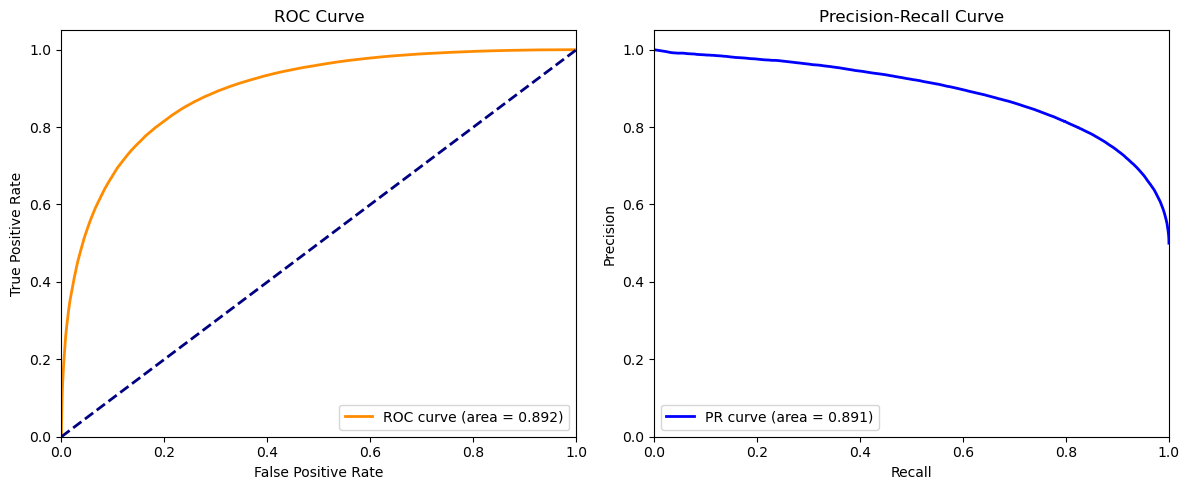


Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81    160000
    Positive       0.81      0.80      0.81    160000

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81    160000
    Positive       0.81      0.80      0.81    160000

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



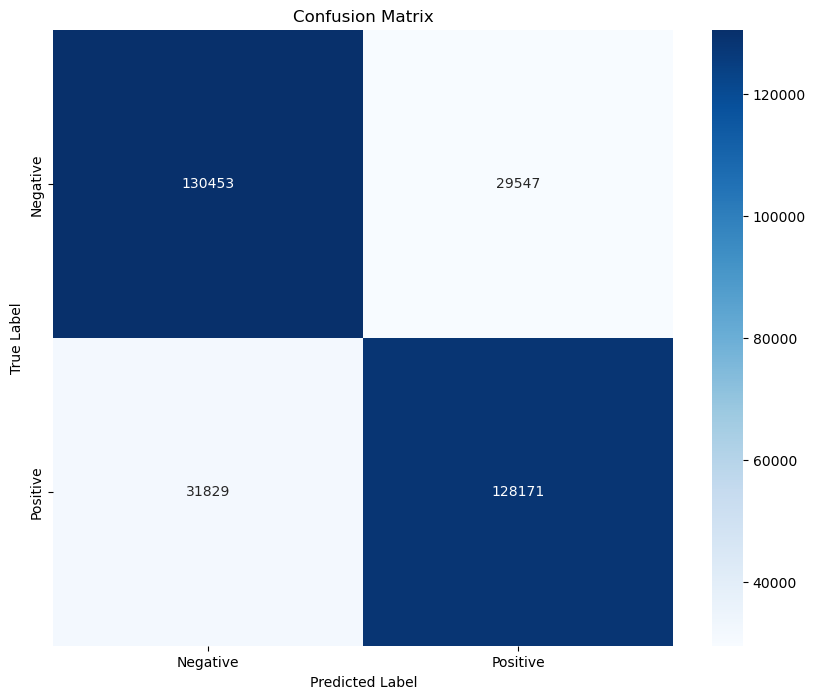

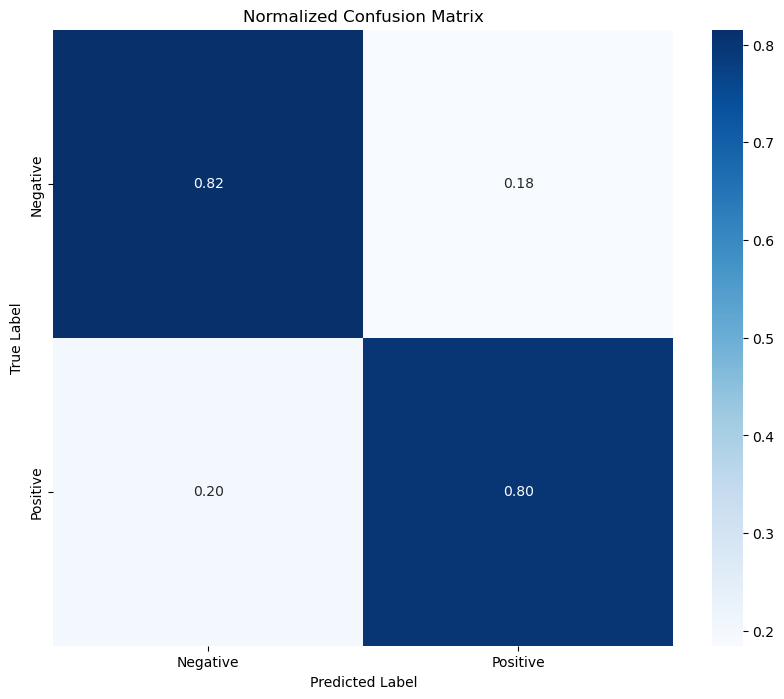

In [11]:
# Enhanced RoBERTa evaluation with additional metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Get predictions with probabilities (not just class labels)
raw_pred, labels, _ = trainer.predict(test_dataset)
y_scores = raw_pred[:, 1]  # Probability for positive class
y_pred = np.argmax(raw_pred, axis=1)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(labels, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, y_scores, pos_label=1)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Print detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(labels, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix with percentages
cm = confusion_matrix(labels, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Error Analysis - Examine Misclassifications

In [12]:
# Identify and analyze misclassifications
test_texts = test_df['text'].values
test_labels = test_df['label'].values

# Create a DataFrame to store predictions and analysis
analysis_df = pd.DataFrame({
    'text': test_texts,
    'true_label': test_labels,
    'predicted_label': y_pred,
    'positive_prob': y_scores,
})

# Add a column to identify misclassifications
analysis_df['correct'] = analysis_df['true_label'] == analysis_df['predicted_label']

# Add human-readable labels
analysis_df['true_sentiment'] = analysis_df['true_label'].map({0: 'Negative', 1: 'Positive'})
analysis_df['predicted_sentiment'] = analysis_df['predicted_label'].map({0: 'Negative', 1: 'Positive'})

# Examine the most confidently wrong predictions
false_pos = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1)]
false_neg = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0)]

# Sort by confidence (probability)
false_pos = false_pos.sort_values(by='positive_prob', ascending=False)
false_neg = false_neg.sort_values(by='positive_prob')

print(f"Total misclassifications: {len(analysis_df) - analysis_df['correct'].sum()} / {len(analysis_df)} "
      f"({(1 - analysis_df['correct'].mean()) * 100:.2f}%)")
print(f"False positives: {len(false_pos)} (Negative classified as Positive)")
print(f"False negatives: {len(false_neg)} (Positive classified as Negative)")

# Display most confidently incorrect predictions
print("\nTop 5 Most Confident False Positives (Negative predicted as Positive):")
for i, (_, row) in enumerate(false_pos.head(5).iterrows()):
    print(f"{i+1}. Text: {row['text']}")
    print(f"   Confidence: {row['positive_prob']:.4f}\n")

print("\nTop 5 Most Confident False Negatives (Positive predicted as Negative):")
for i, (_, row) in enumerate(false_neg.head(5).iterrows()):
    print(f"{i+1}. Text: {row['text']}")
    print(f"   Confidence: {1 - row['positive_prob']:.4f}\n")

Total misclassifications: 61376 / 320000 (19.18%)
False positives: 29547 (Negative classified as Positive)
False negatives: 31829 (Positive classified as Negative)

Top 5 Most Confident False Positives (Negative predicted as Positive):
1. Text: out of bath bombs  time to go to lush!
   Confidence: 1.8330

2. Text: @10TheDoctor10 ( *comfort*  We're all your friends here or good acquaintances. We all share a common interest. )
   Confidence: 1.8330

3. Text: @billpalmer welcome to the new facebook! 
   Confidence: 1.8330

4. Text: @ramn Welcome back... Talk to you soon... I am up resolving a production issue 
   Confidence: 1.8330

5. Text: Diversity was pretty awesome. There was a beautiful rainbow in the sky yesterday, but no pot of gold 
   Confidence: 1.8330


Top 5 Most Confident False Negatives (Positive predicted as Negative):
1. Text: I cut my hand while doing pull-ups, I did a few more sets after the minor injury. 
   Confidence: 2.8555

2. Text: @Wendy_AM Not sad at all!  I wan

## Save Models for Deployment

In [13]:
import os

# Create directory for saved models
os.makedirs('./saved_models', exist_ok=True)

# Save classical models
joblib.dump(models['Naive Bayes'], './saved_models/naive_bayes_model.pkl')
joblib.dump(models['Logistic Regression'], './saved_models/logistic_regression_model.pkl')
joblib.dump(tfidf_vectorizer, './saved_models/tfidf_vectorizer.pkl')

# Save preprocessing function for deployment
joblib.dump(clean_tweet, './saved_models/tweet_cleaner.pkl')

# Save RoBERTa model with version name indicating full training
roberta_path = './saved_models/roberta_full_model'
trainer.model.save_pretrained(roberta_path)
tokenizer.save_pretrained(roberta_path)

# Save model performance metrics for reference
with open('./saved_models/model_metrics.json', 'w') as f:
    import json
    json.dump(results, f, default=str)

print("All models saved successfully")

All models saved successfully
